In [141]:
from PIL import Image
from skimage.io import imread_collection
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import pywt as ptw
from sklearn.utils import shuffle
import time
from random import randint
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [142]:
def draw(image):
    plt.imshow(image)
    plt.show()
    return

def hwavelet(images, n):
    cA = images
    for i in range(n):
        cA, (cH, cV, cD) = ptw.dwt2(cA, 'haar')
    return cA

def normalizar(dataset):
    aux = []
    for i in range(len(dataset)):
        aux = aux + [dataset[i].reshape(24*24).tolist()]
    return aux

In [143]:
ANGER = 0
CONTEMPT = 1
DISGUST = 2
FEAR = 3
HAPPY = 4
SADNESS = 5
SURPRISE = 6

# paths
pathAnger = 'images/anger/*.png'
pathContempt = 'images/contempt/*.png'
pathDisgust = 'images/disgust/*.png'
pathFear = 'images/fear/*.png'
pathHappy = 'images/happy/*.png'
pathSadness = 'images/sadness/*.png'
pathSurprise = 'images/surprise/*.png'

#images
imagesAnger = imread_collection(pathAnger)
imagesContempt = imread_collection(pathContempt)
imagesDisgust = imread_collection(pathDisgust)
imagesFear = imread_collection(pathFear)
imagesHappy = imread_collection(pathHappy)
imagesSadness = imread_collection(pathSadness)
imagesSurprise = imread_collection(pathSurprise)

# Haar Wavelet
imagesAngerHW = hwavelet(imagesAnger, 1)
imagesContemptHW = hwavelet(imagesContempt, 1)
imagesDisgustHW = hwavelet(imagesDisgust, 1)
imagesFearHW = hwavelet(imagesFear, 1)
imagesHappyHW = hwavelet(imagesHappy, 1)
imagesSadnessHW = hwavelet(imagesSadness, 1)
imagesSurpriseHW = hwavelet(imagesSurprise, 1)

# Normalizacion
anger = normalizar(imagesAngerHW)
contempt = normalizar(imagesContemptHW)
disgust = normalizar(imagesDisgustHW)
fear = normalizar(imagesFearHW)
happy = normalizar(imagesHappyHW)
sadness = normalizar(imagesSadnessHW)
surprise = normalizar(imagesSurpriseHW)

def target_vector():
  return ['ANGER']*len(anger) + ['CONTEMPT']*len(contempt) + ['DISGUST']*len(disgust) \
    + ['FEAR']*len(fear) + ['HAPPY']*len(happy) + ['SADNESS']*len(sadness) \
    + ['SURPRISE']*len(surprise)

X = anger + contempt + disgust + fear + happy + sadness + surprise
Y = target_vector()

X, Y = shuffle(X, Y)

print(len(X))
print(len(Y))

# ajuste = svm.SVC(gamma=0.001, C=100)
# ajuste.fit(X, Y)

# molesto = 'test/S010_004_00000017.png'

# img = Image.open(molesto)
# img_wavelet = hwavelet(img, 1)
# normalized_img = normalizar([img_wavelet])[0]
# # print(len(normalized_img))
# print('prediction: ', ajuste.predict([normalized_img]))
    

981
981


In [144]:
def k_folds(x, y, modelo, k = 10):
    # indices para el testing
    inicio = 0
    fin = 0
    block = len(x) / k
    error = 0
    errores = []
    varianza = 0

    # Resultado por cada grupo (buenas y malas)
    result = []

    for i in range(k):
        # Limites del bloque de test
        inicio = block * i
        fin = block * (i + 1)

        x_testing = []
        y_testing = []
        x_training = []
        y_training = []
        y_prediction = []

        # Separar los bloques
        for idx, punto in enumerate(x):
            if idx < inicio or idx > fin:
                x_training.append(punto)
                y_training.append(y[idx])
            else:
                x_testing.append(punto)
                y_testing.append(y[idx])

        # Crear modelo
        modelo = modelo.fit(x_training, y_training)
        # tree.plot_tree(modelo)

        # Testing
        buenas = 0
        malas = 0
        for idx, punto in enumerate(x_testing):
            prediccion = modelo.predict([punto])
            y_prediction.append(prediccion)
            if prediccion == y_testing[idx]:
                buenas += 1
            else:
                malas += 1
        matrix = confusion_matrix(y_testing, y_prediction, labels=["ANGER", "CONTEMPTY", "DISGUST", "FEAR", "HAPPY", "SADNESS", "SURPRISE"])
        result.append([modelo, x_testing, y_testing])

        # Error (1 - (buenas/total))
        error_i = 1 - (sum([matrix[indice][indice] for indice in range(len(matrix))]) / np.sum(matrix))
        error += error_i
        errores.append(error_i)
    
    # Varianza
    error_promedio = error/k
    for error_i in errores:
        varianza += (error_i - error_promedio)**2
    varianza /= (k - 1)
    f = open("experimentos.txt", "a")
    f.write(' & ' + str(round(error_promedio, 4)) + ' & ' + str(round(varianza, 4)))
    f.close()
    print('El error es de:', error_promedio)
    print('La varianza es de:', varianza)
    return result

In [145]:
def bootstrap(x, y, modelo, k = 10):
    N = len(x)
    result = []
    error = 0
    errores = []
    varianza = 0
    p = 8

    i = 0
    
    while i < k:
        x_testing = []
        y_testing = []
        x_training = []
        y_training = []
        y_prediction = []
        indices = [0] * N # Para saber cuales estan en el training y no ponerlos en el testing
        
        # Escoger los N para el training
        while len(x_training) < N:
            for idx, punto in enumerate(x):
                if len(x_training) >= N:
                    break
                value = randint(0, 10)
                if value <= p: # p% de posibilidades
                    x_training.append(punto)
                    y_training.append(y[idx])
                    indices[idx] = 1

        # Escoger el resto para el testing
        for idx, punto in enumerate(x):
            if indices[idx] == 0:
                x_testing.append(punto)
                y_testing.append(y[idx])

        # El testing esta vacio, repetir experimento
        if len(x_testing) == 0:
            continue

        # Crear modelo
        modelo = modelo.fit(x_training, y_training)

        # Testing
        buenas = 0
        malas = 0
        for idx, punto in enumerate(x_testing):
            prediccion = modelo.predict([punto])
            y_prediction.append(prediccion)
            if prediccion == y_testing[idx]:
                buenas += 1
            else:
                malas += 1
        matrix = confusion_matrix(y_testing, y_prediction, labels=["ANGER", "CONTEMPTY", "DISGUST", "FEAR", "HAPPY", "SADNESS", "SURPRISE"])
        result.append([modelo, x_testing, y_testing])

        # Error (1 - (buenas/total))
        error_i = 1 - (sum([matrix[indice][indice] for indice in range(len(matrix))]) / np.sum(matrix))
        error += error_i
        errores.append(error_i)

        i += 1
    # Varianza
    error_promedio = error/k
    for error_i in errores:
        varianza += (error_i - error_promedio)**2
    varianza /= (k - 1)
    f = open("experimentos.txt", "a")
    f.write(' & ' + str(round(error_promedio, 4)) + ' & ' + str(round(varianza, 4)))
    f.close()
    print('El error es de:', error_promedio)
    print('La varianza es de:', varianza)
    return result


K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


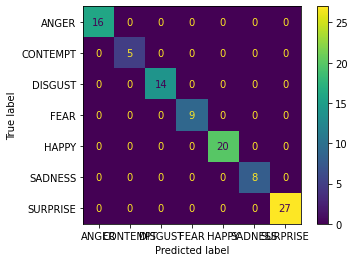

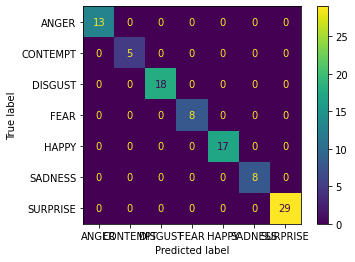

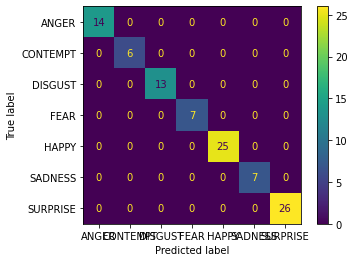

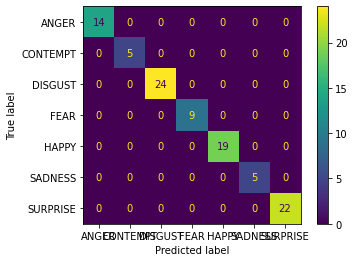

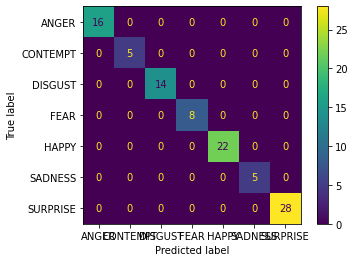

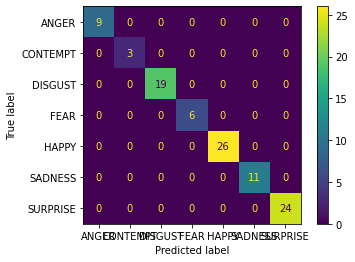

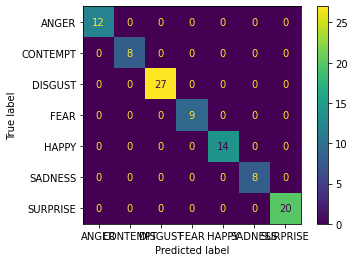

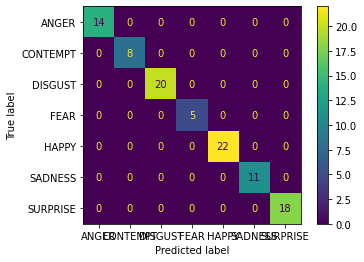

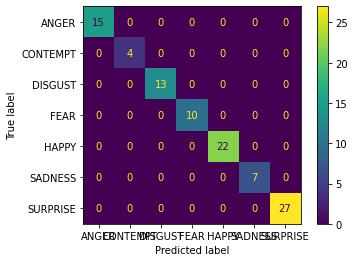

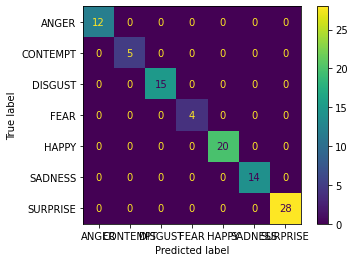

BOOTSTRAP
El error es de: 0.0028240740740740787
La varianza es de: 4.5460390946502203e-05
PROMEDIO:  0.9989238977432251


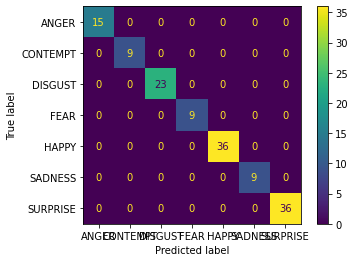

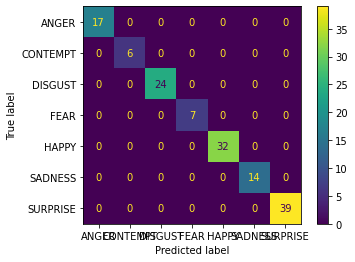

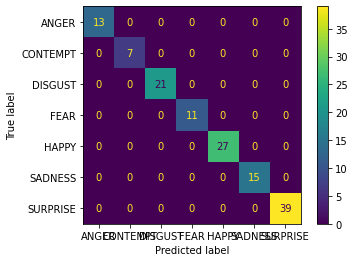

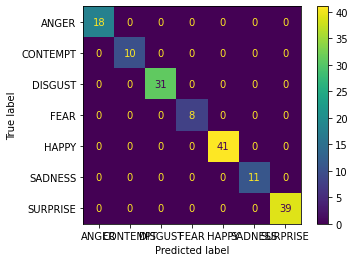

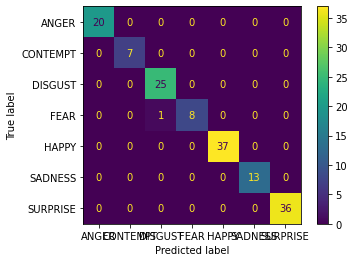

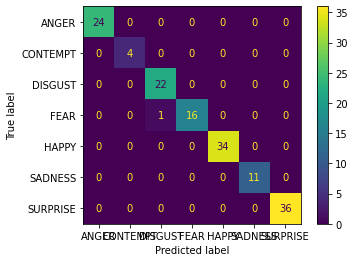

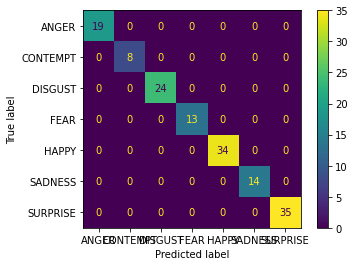

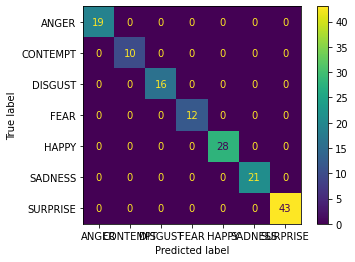

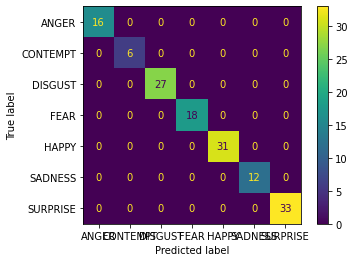

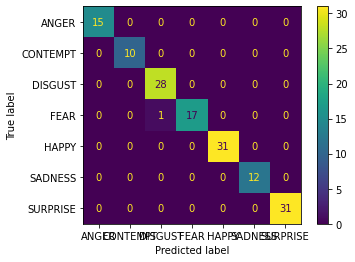

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


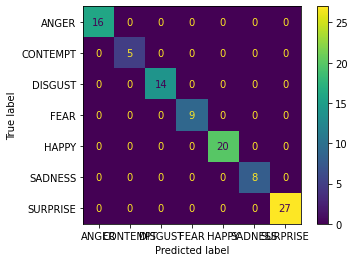

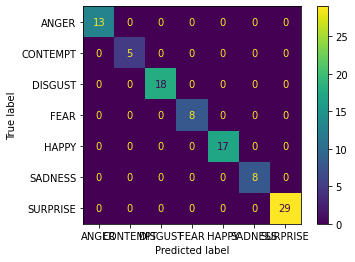

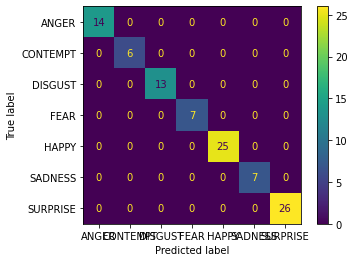

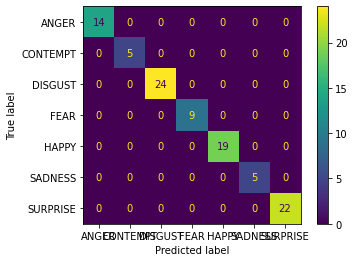

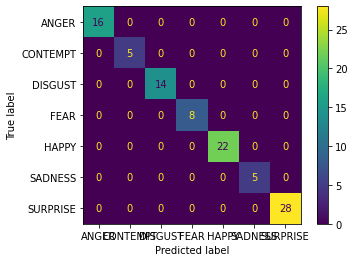

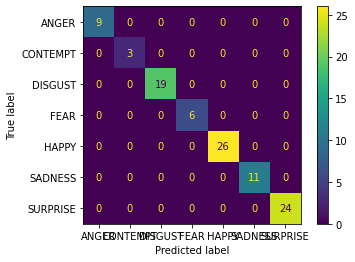

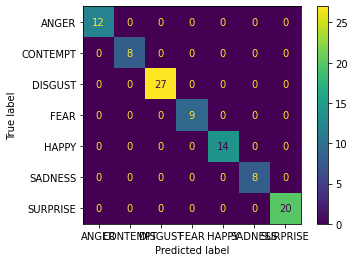

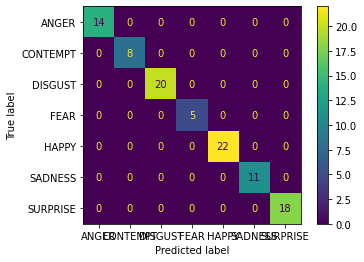

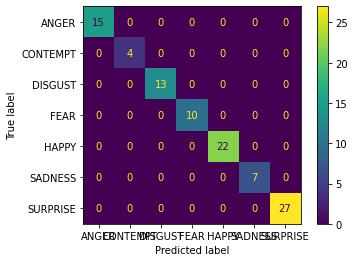

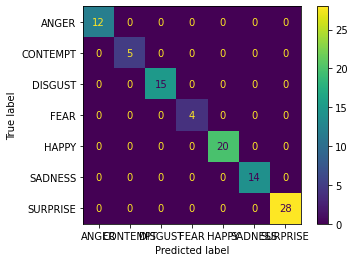

BOOTSTRAP
El error es de: 0.005823857538010513
La varianza es de: 0.00011548170166975707
PROMEDIO:  0.8961796760559082


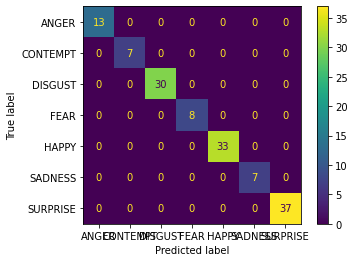

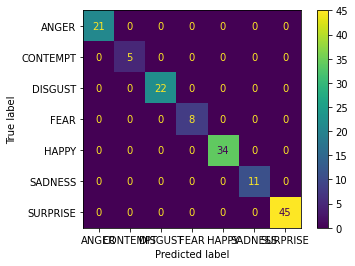

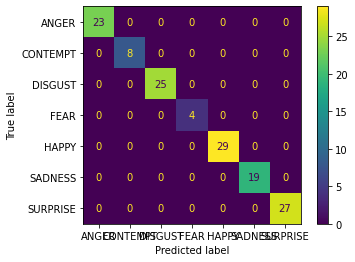

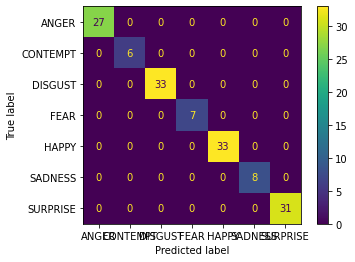

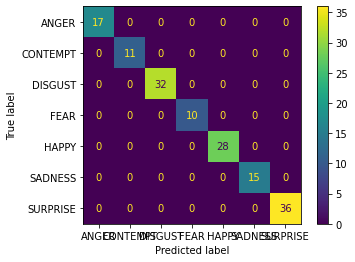

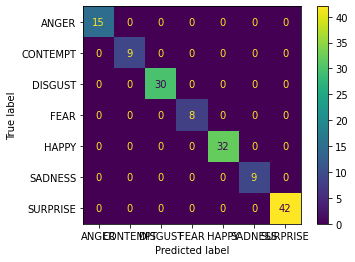

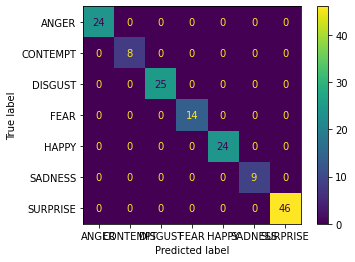

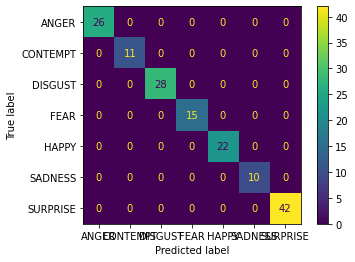

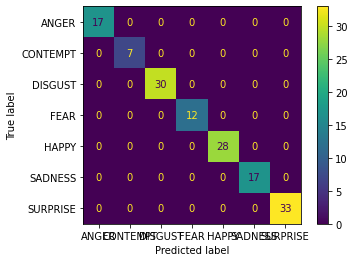

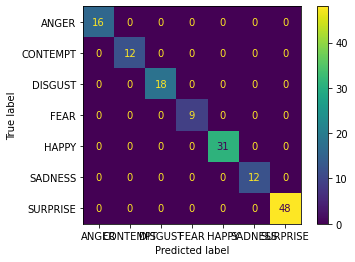

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


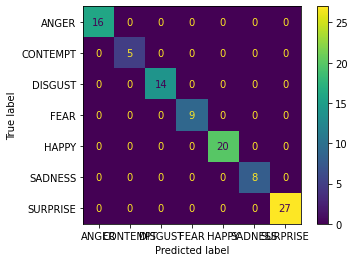

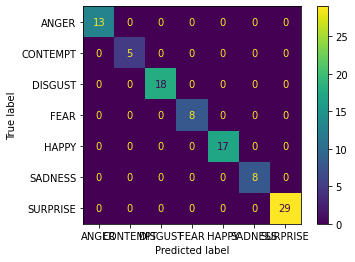

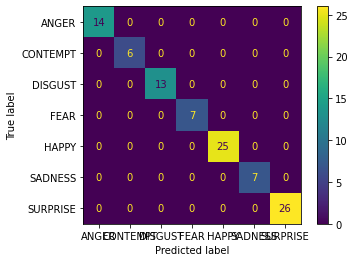

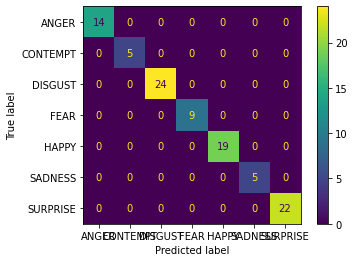

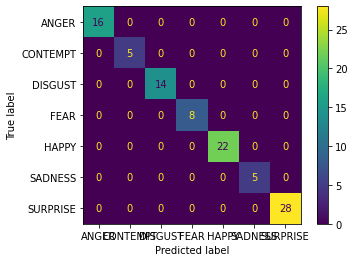

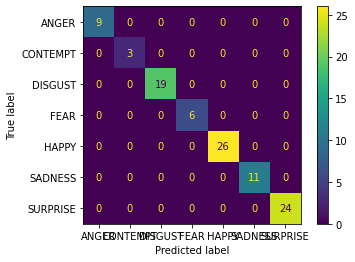

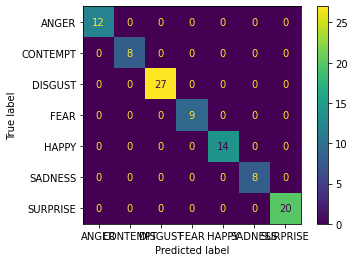

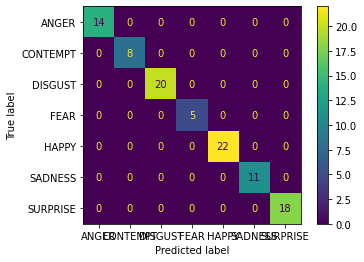

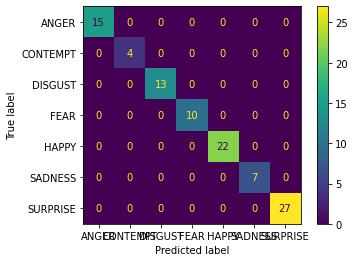

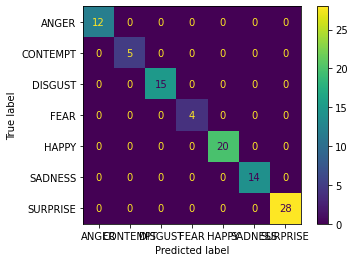

BOOTSTRAP
El error es de: 0.005799971836757445
La varianza es de: 8.29262093789416e-05
PROMEDIO:  0.8782484531402588


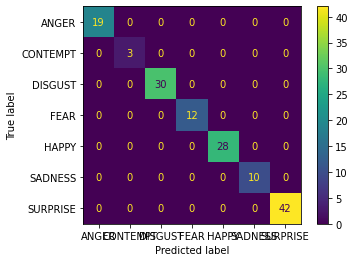

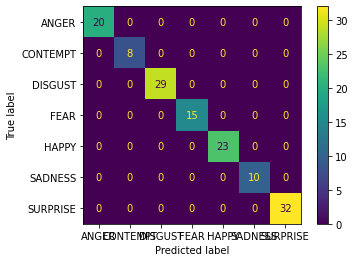

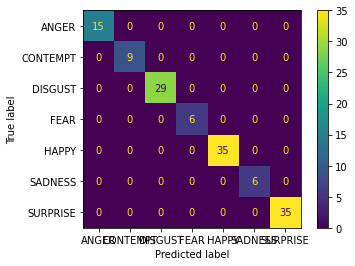

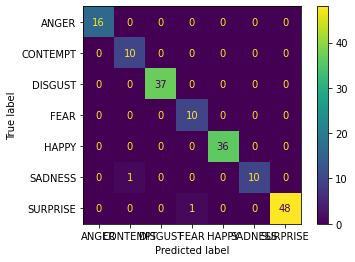

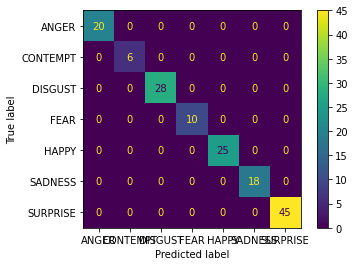

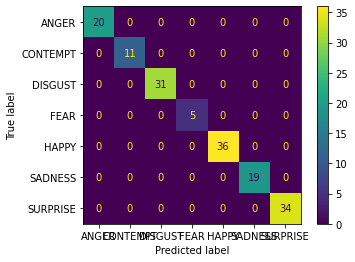

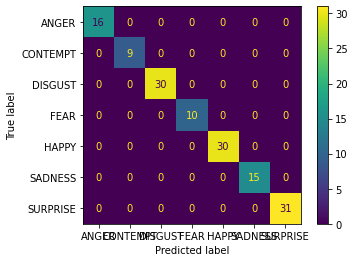

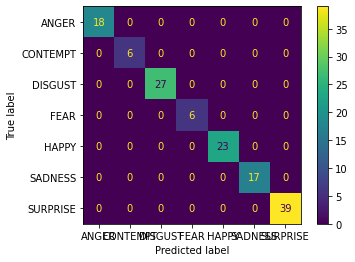

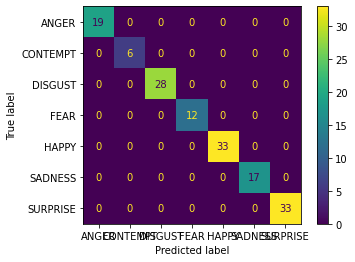

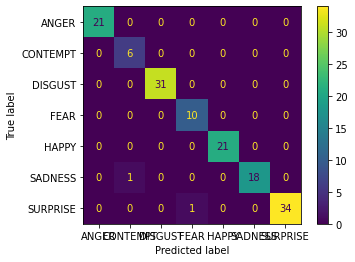

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


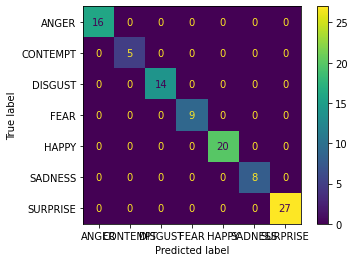

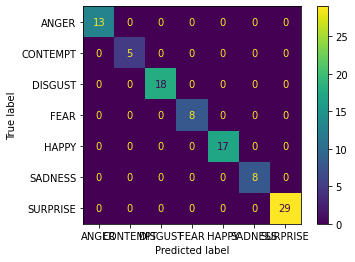

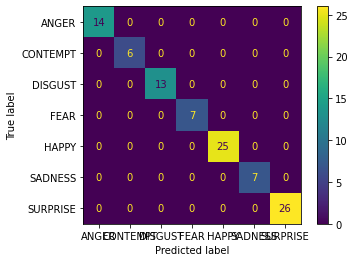

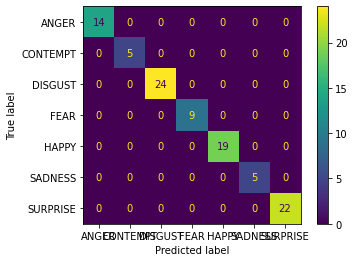

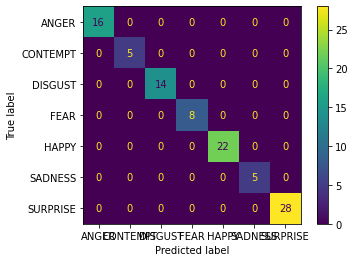

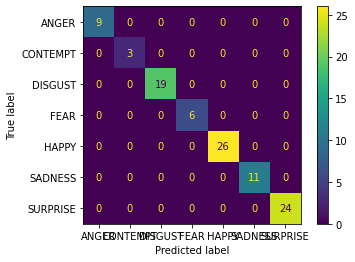

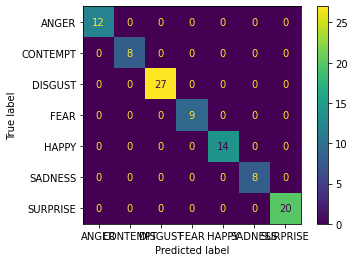

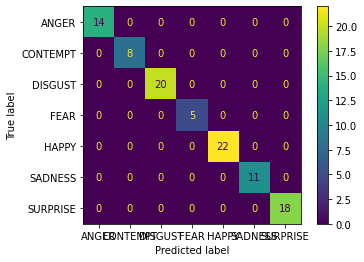

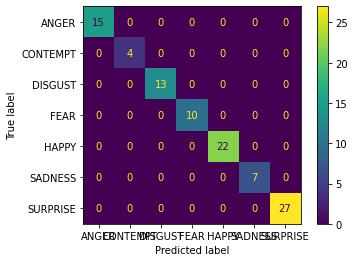

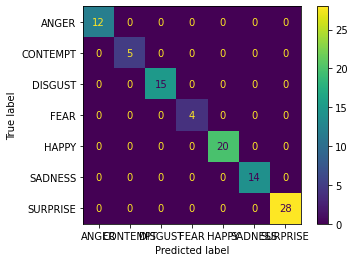

BOOTSTRAP
El error es de: 0.0074715612125684115
La varianza es de: 0.00011263484284233921
PROMEDIO:  0.8613184690475464


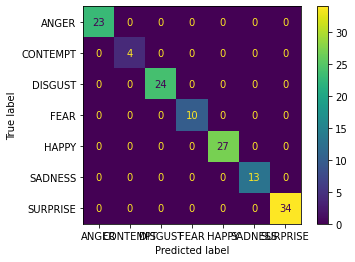

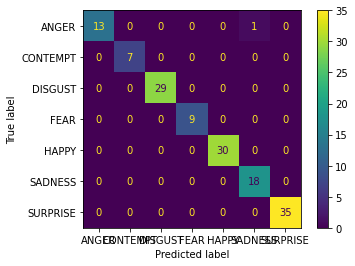

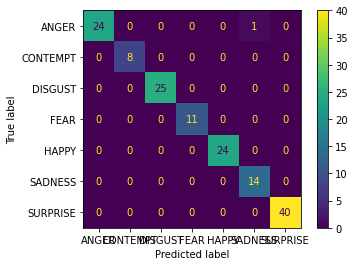

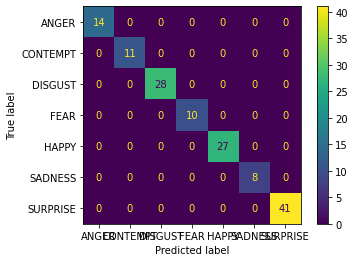

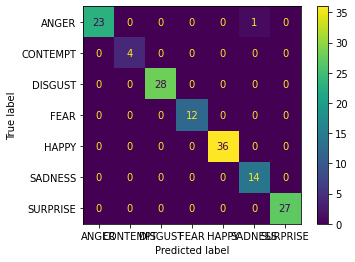

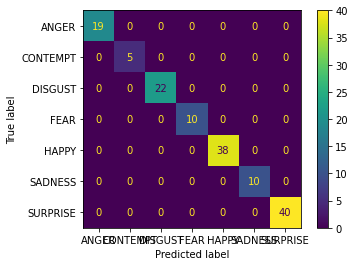

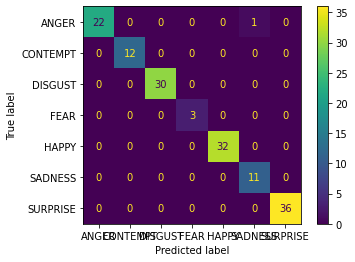

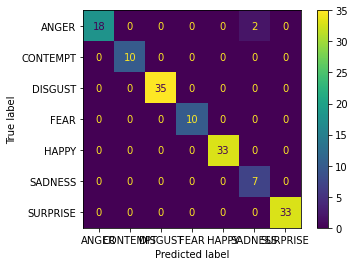

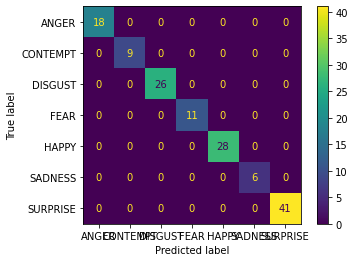

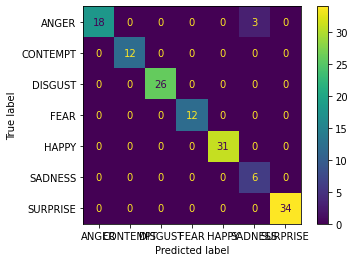

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


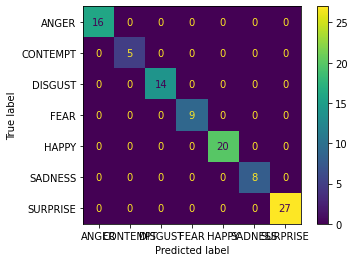

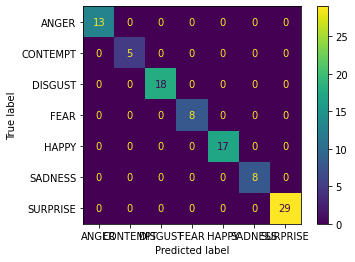

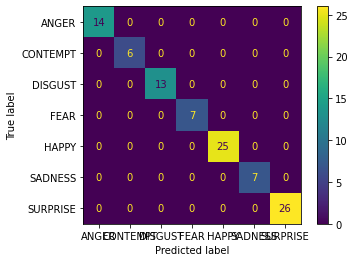

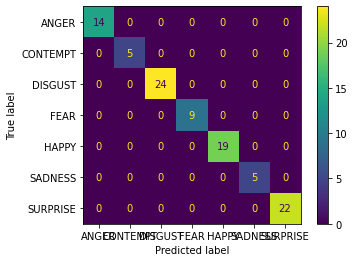

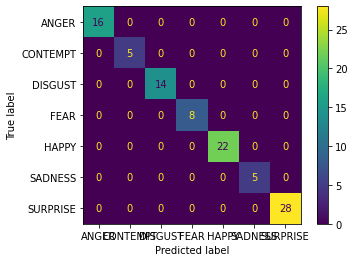

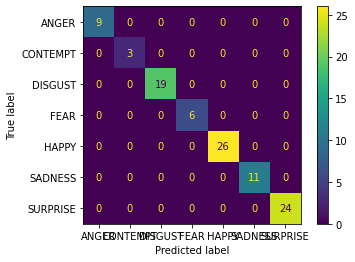

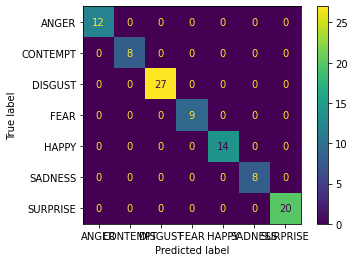

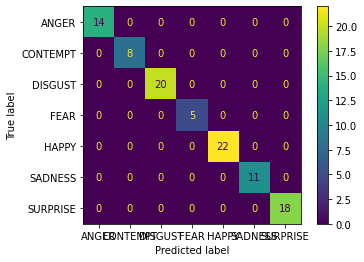

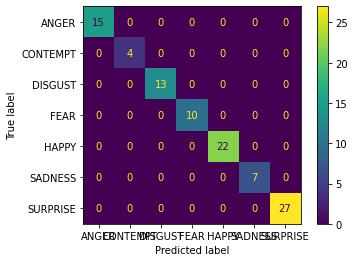

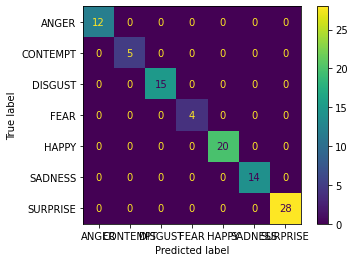

BOOTSTRAP
El error es de: 0.007175027178133242
La varianza es de: 0.0002031952657606268
PROMEDIO:  0.9568978548049927


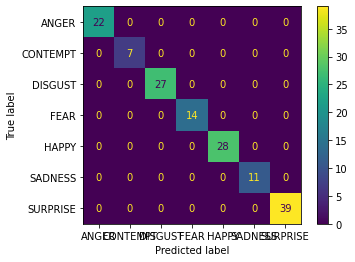

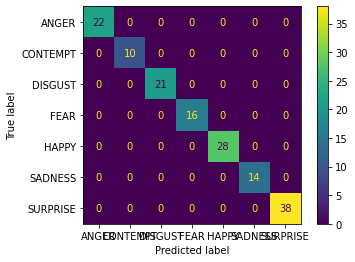

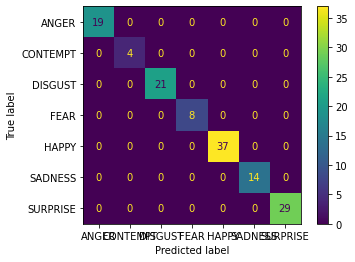

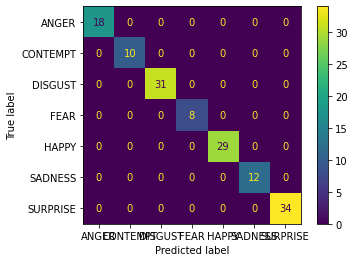

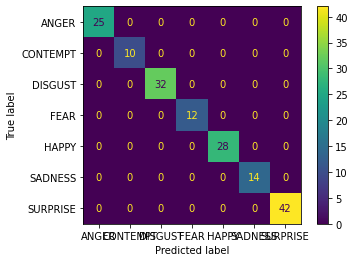

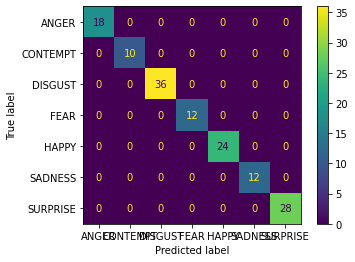

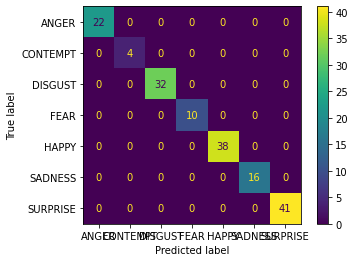

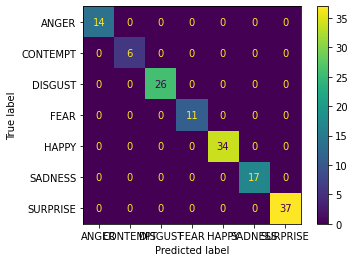

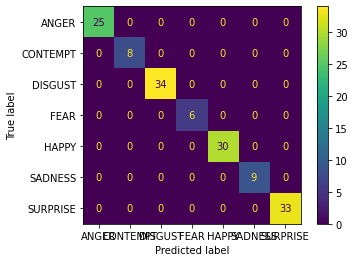

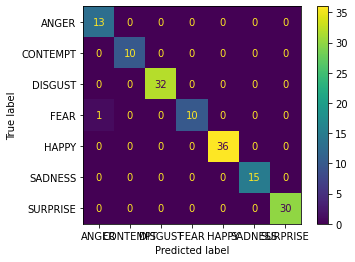

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


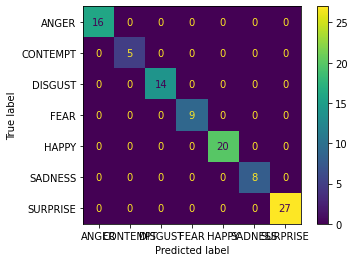

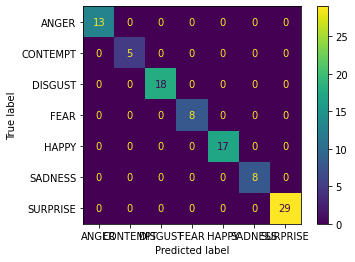

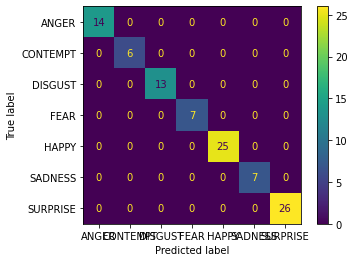

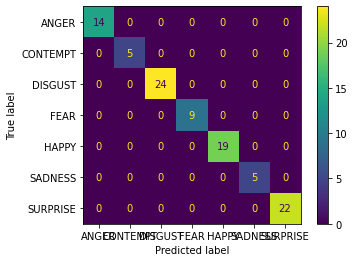

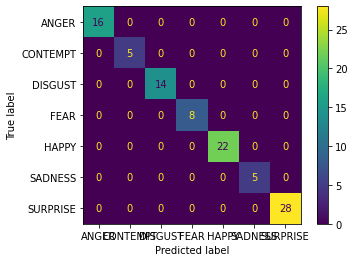

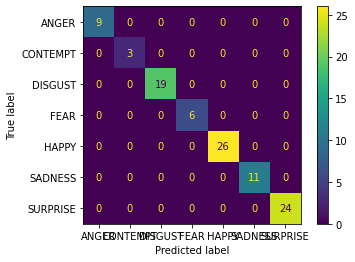

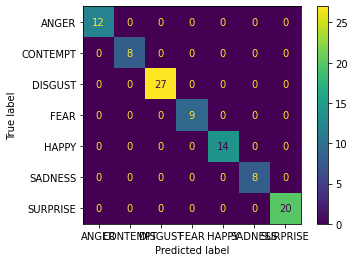

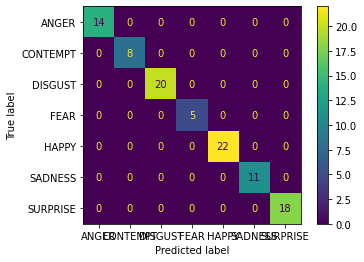

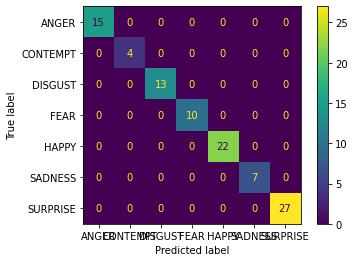

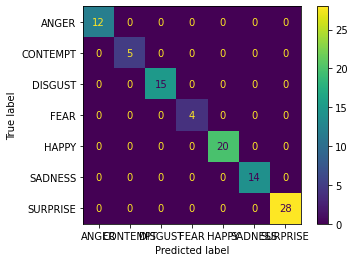

BOOTSTRAP
El error es de: 0.008381119036252571
La varianza es de: 0.0001806813791221804
PROMEDIO:  0.9513490200042725


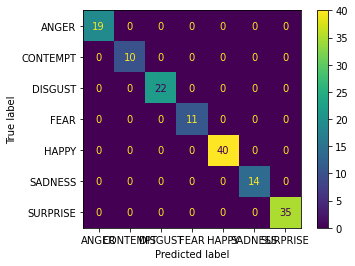

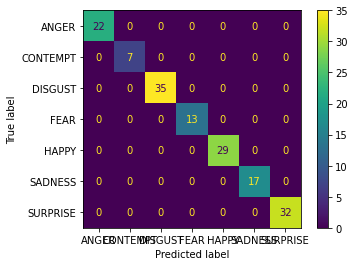

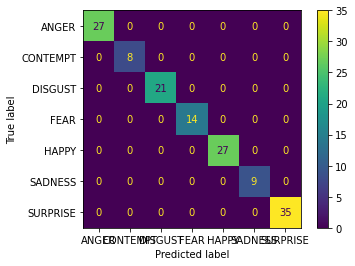

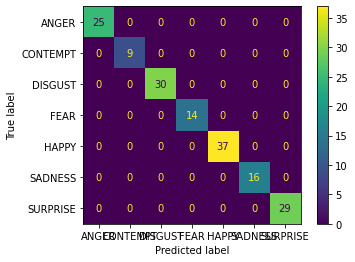

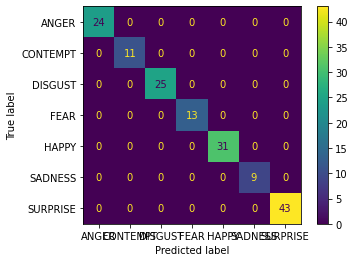

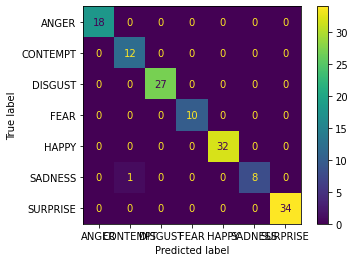

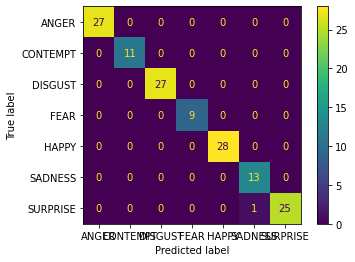

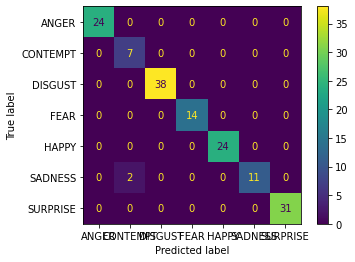

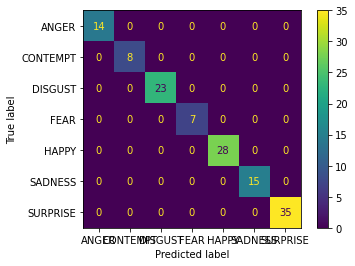

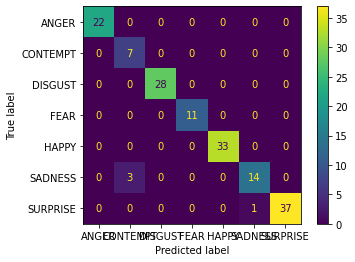

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


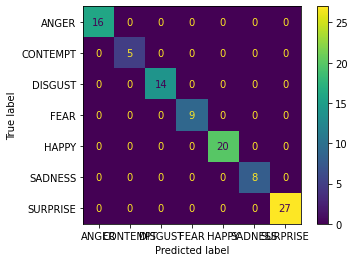

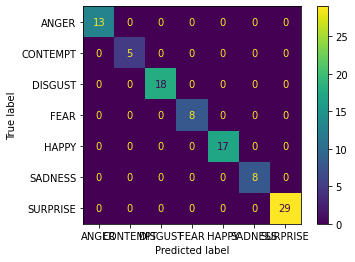

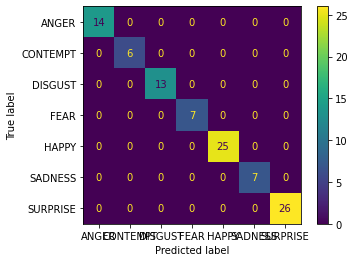

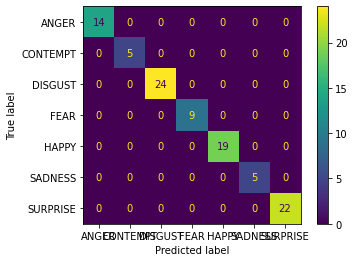

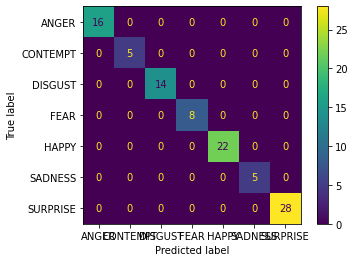

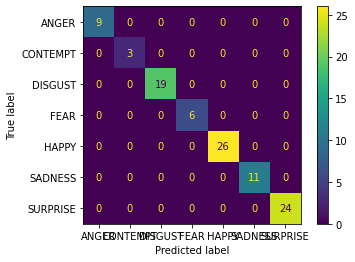

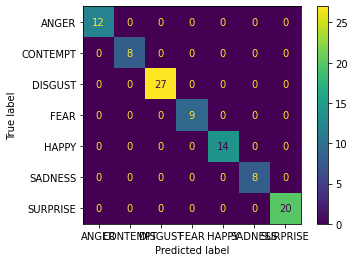

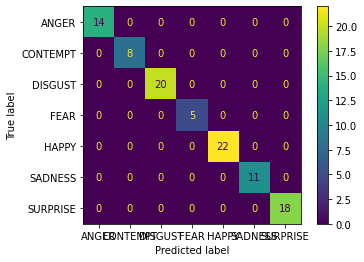

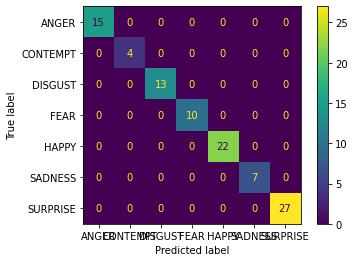

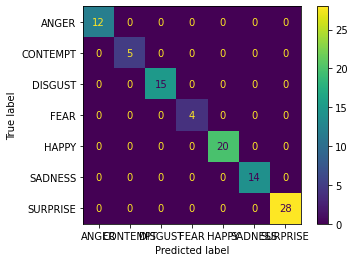

BOOTSTRAP
El error es de: 0.006447395391057364
La varianza es de: 0.00010823101934935014
PROMEDIO:  0.9334605932235718


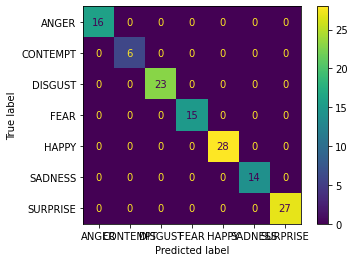

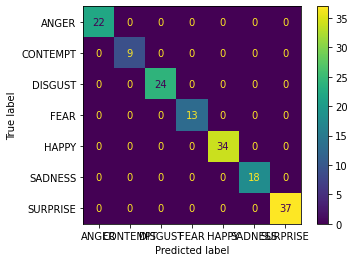

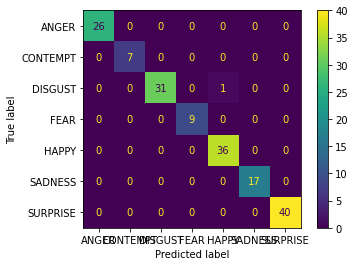

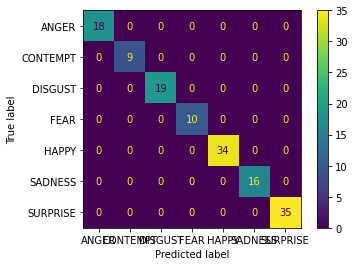

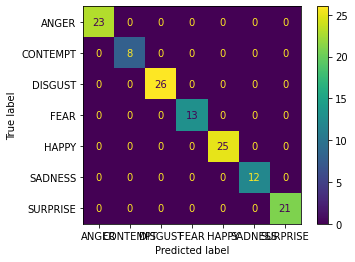

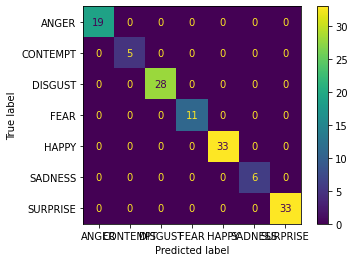

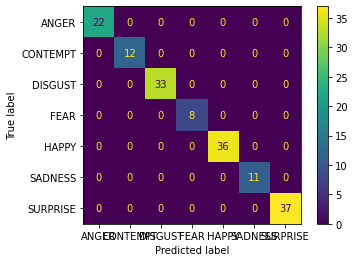

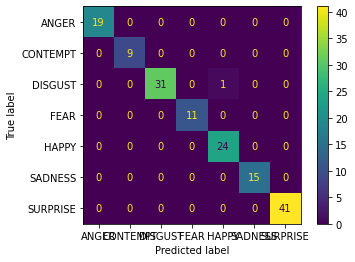

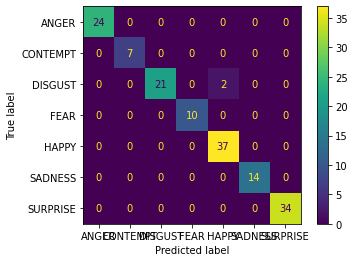

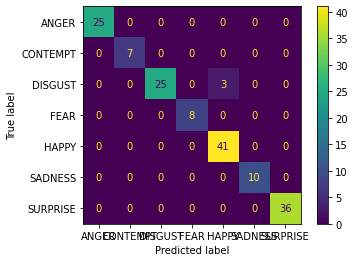

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


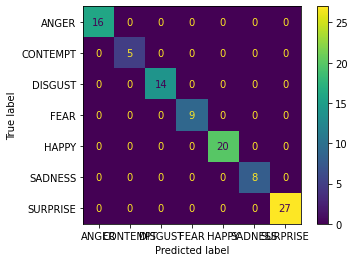

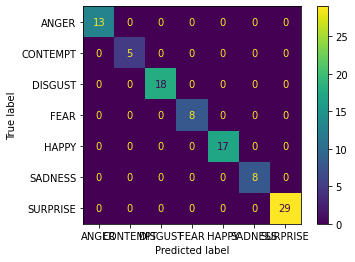

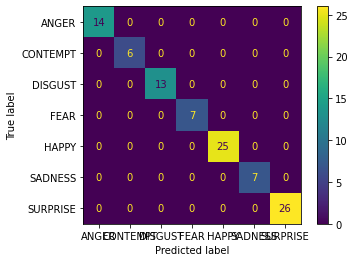

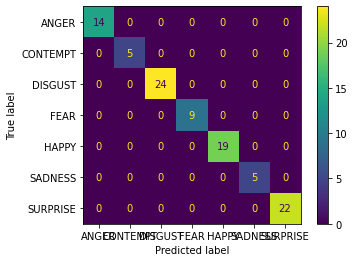

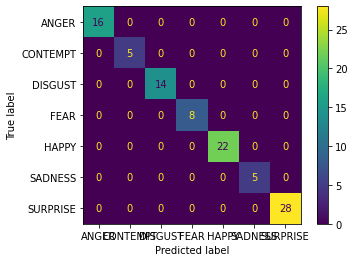

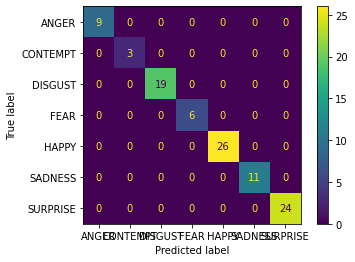

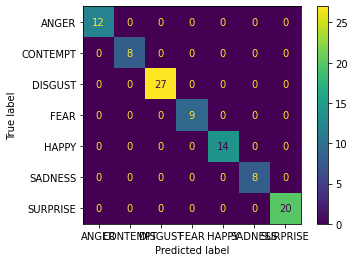

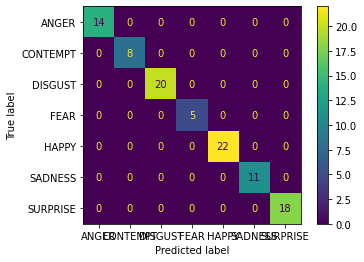

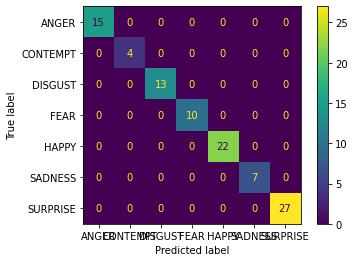

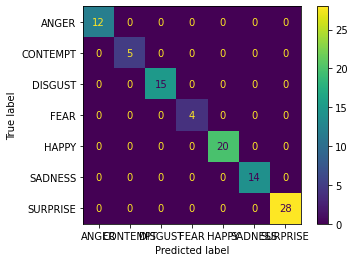

BOOTSTRAP
El error es de: 0.005599881796690309
La varianza es de: 8.511508638435746e-05
PROMEDIO:  0.9259045124053955


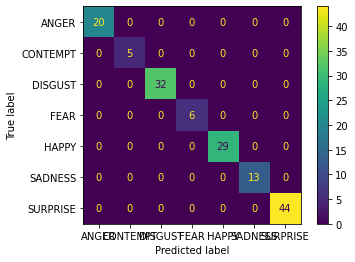

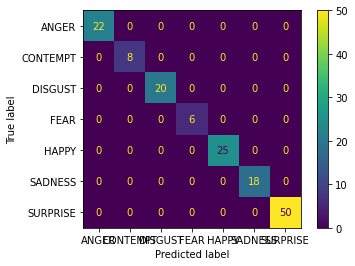

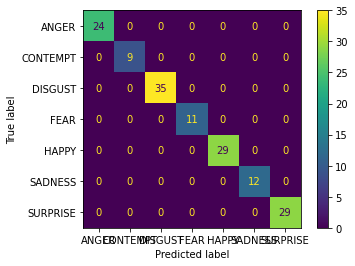

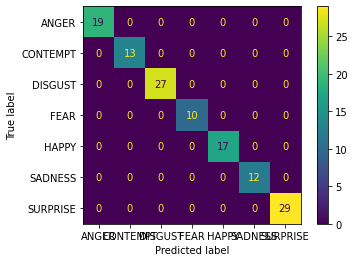

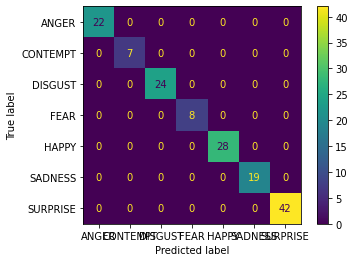

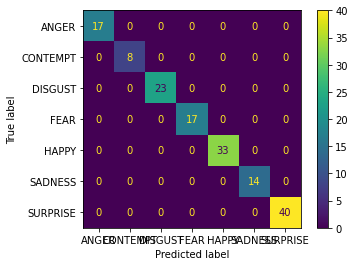

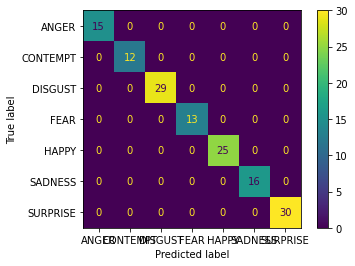

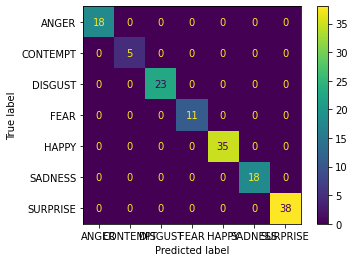

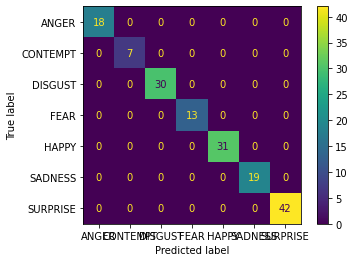

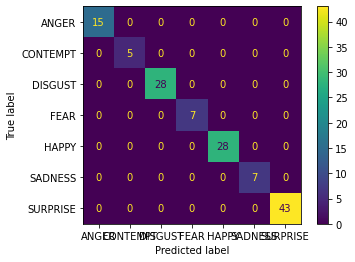

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


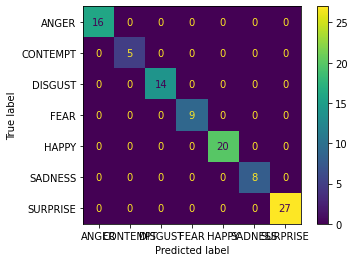

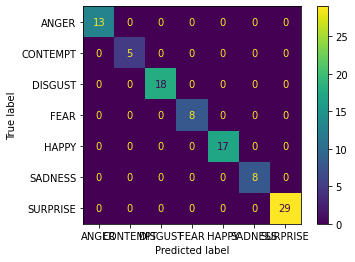

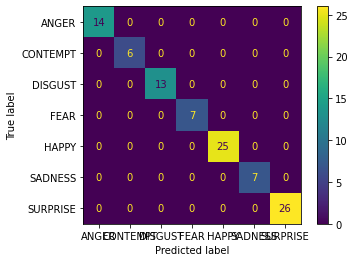

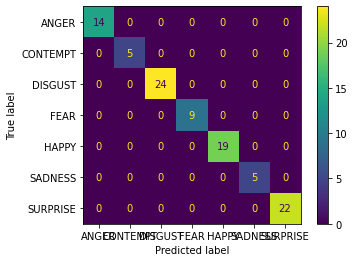

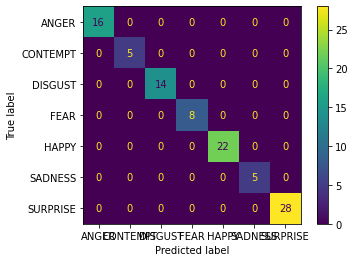

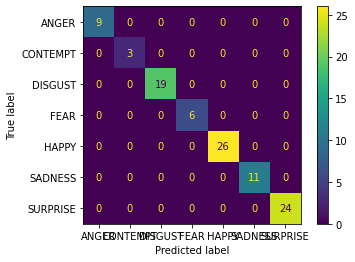

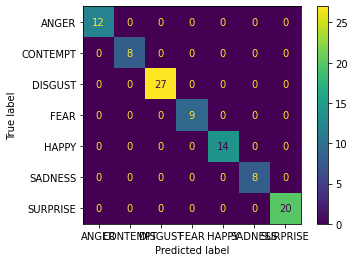

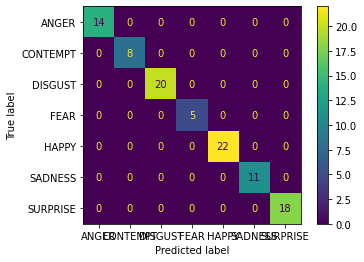

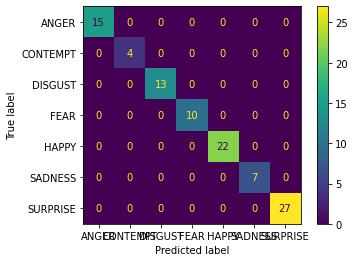

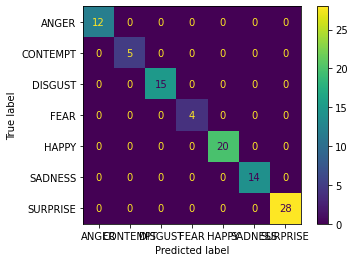

BOOTSTRAP
El error es de: 0.006155167402161566
La varianza es de: 0.00010521565082840628
PROMEDIO:  0.8716363906860352


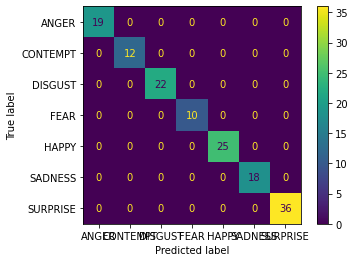

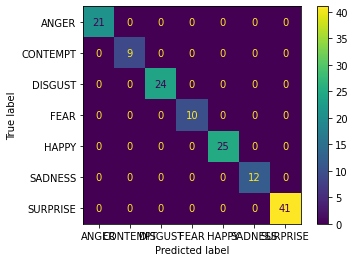

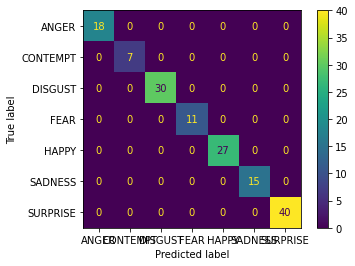

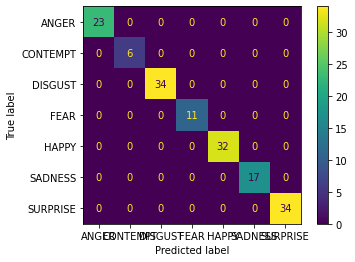

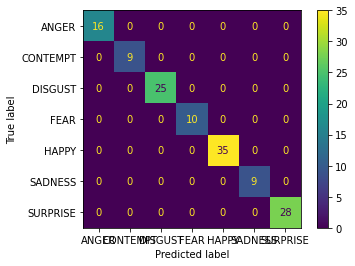

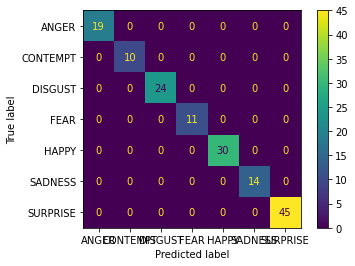

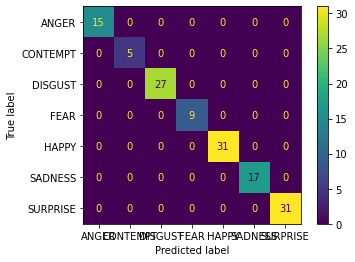

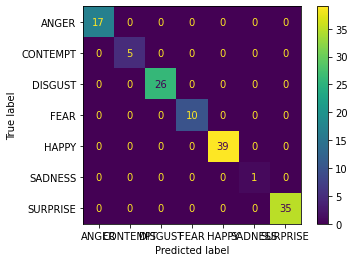

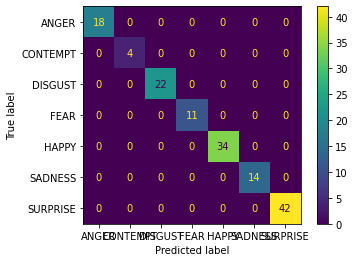

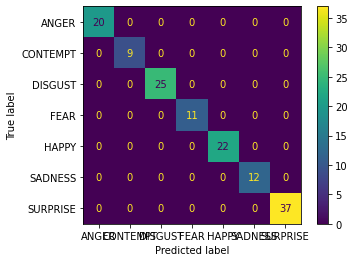

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


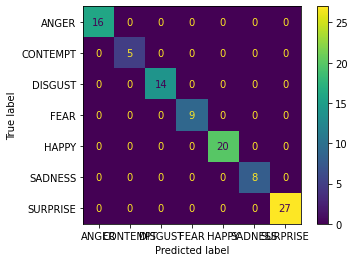

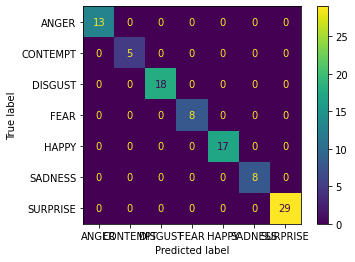

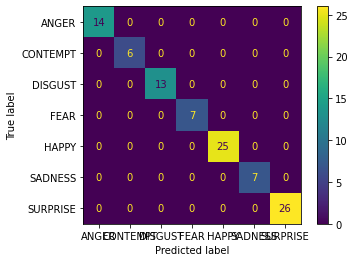

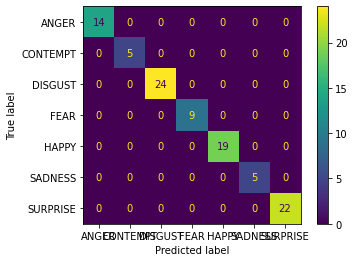

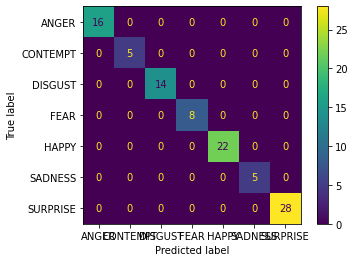

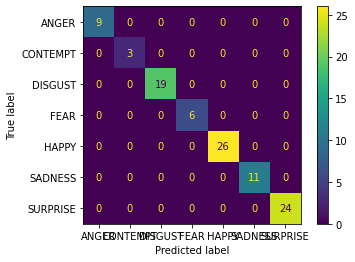

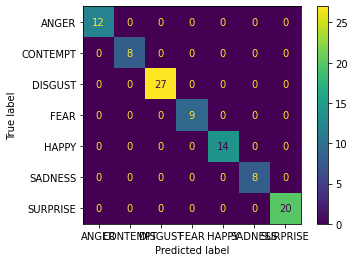

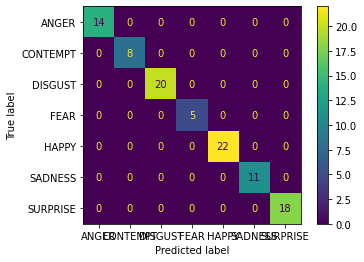

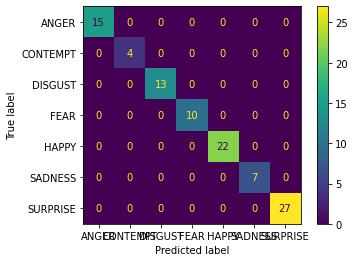

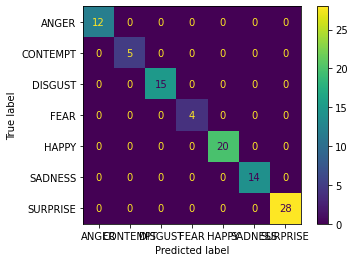

BOOTSTRAP
El error es de: 0.002939122337329758
La varianza es de: 4.758410625566649e-05
PROMEDIO:  0.9272234439849854


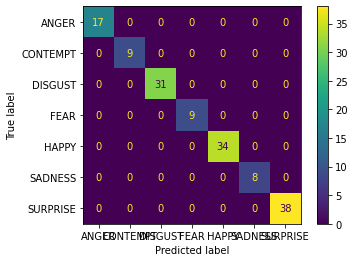

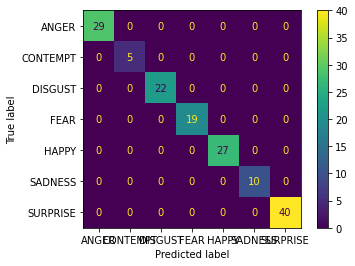

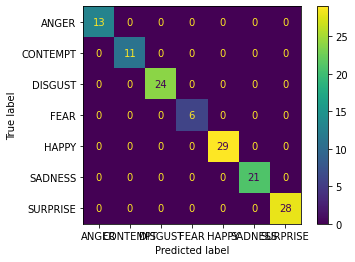

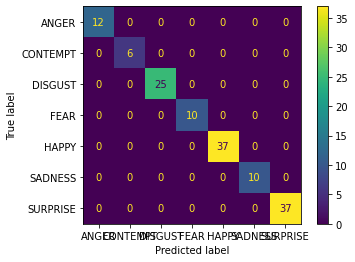

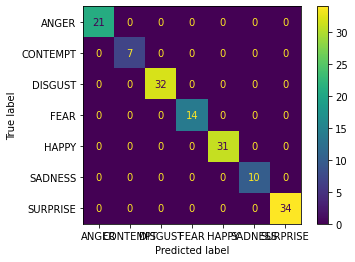

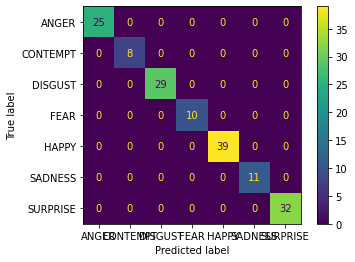

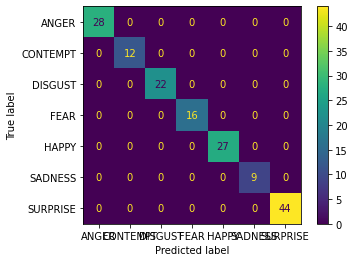

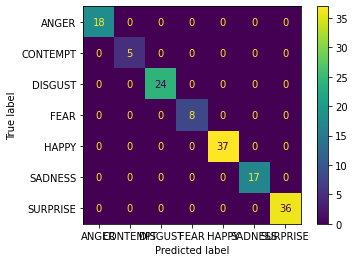

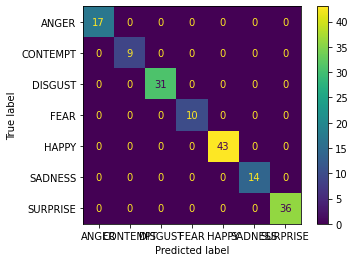

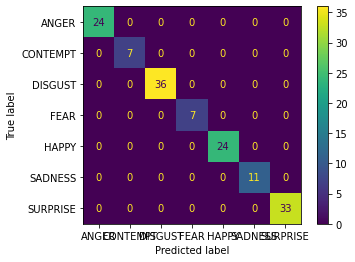

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


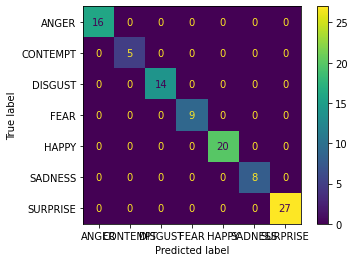

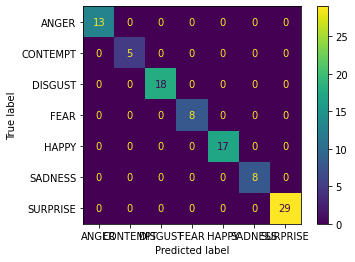

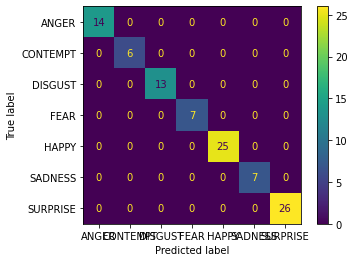

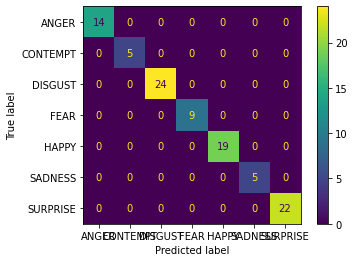

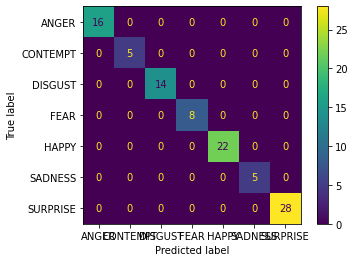

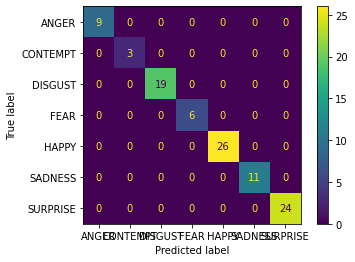

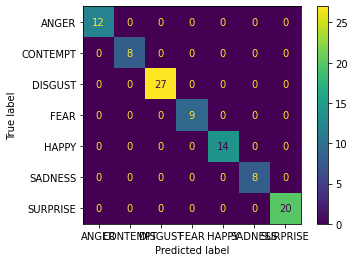

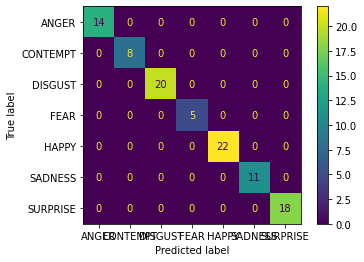

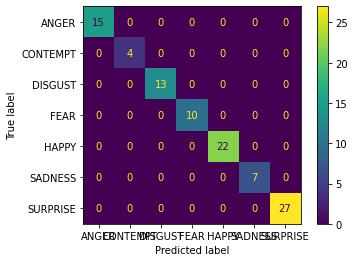

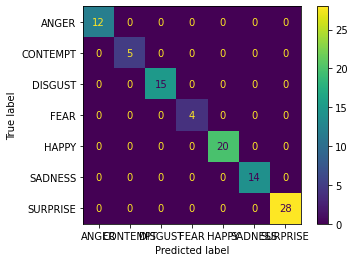

BOOTSTRAP
El error es de: 0.002272727272727271
La varianza es de: 5.1652892561983375e-05
PROMEDIO:  1.246179461479187


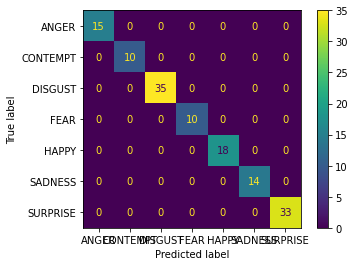

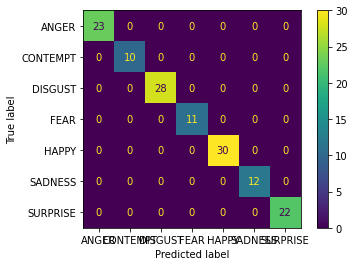

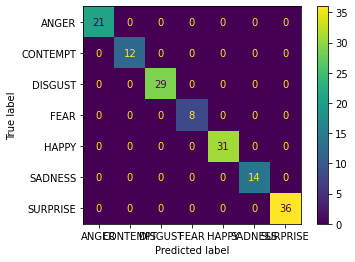

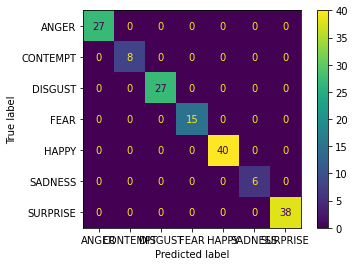

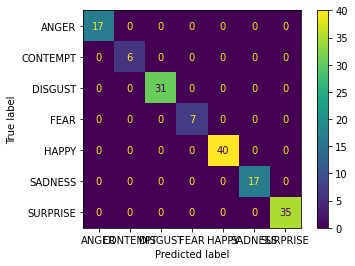

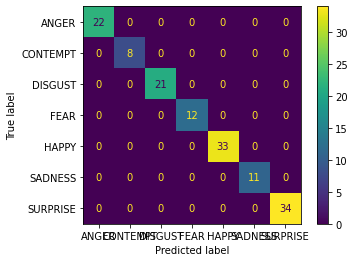

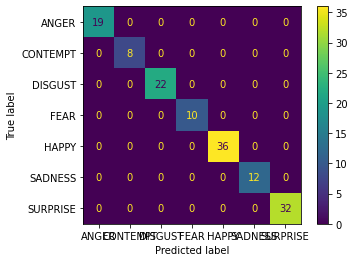

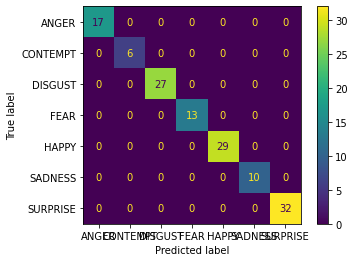

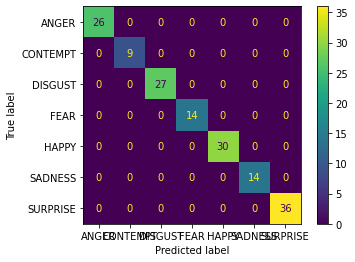

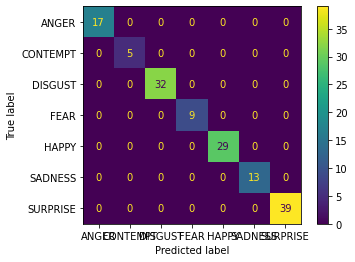

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


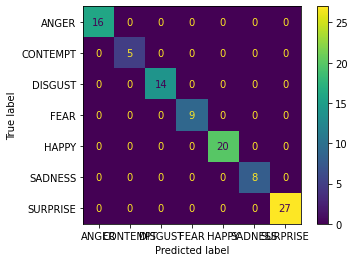

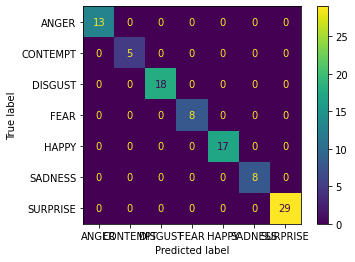

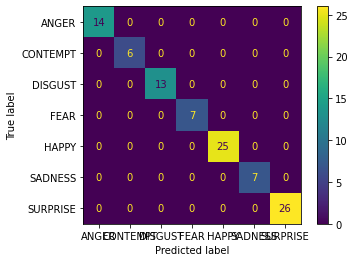

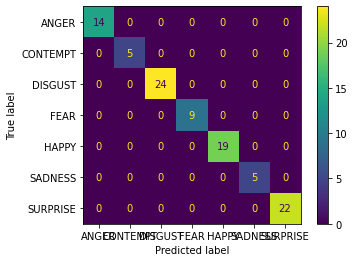

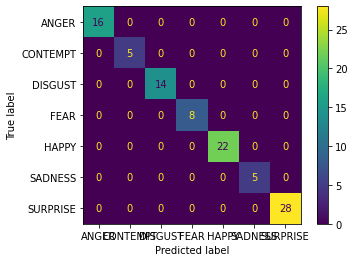

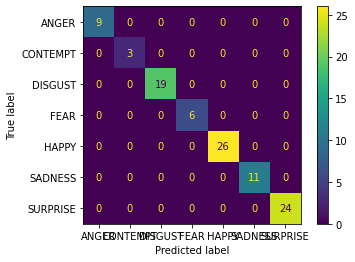

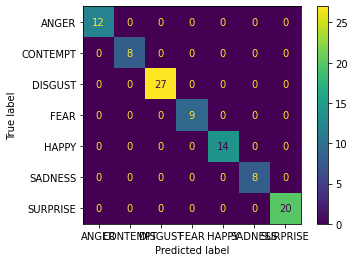

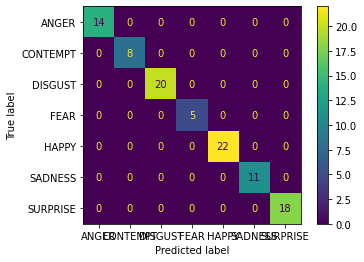

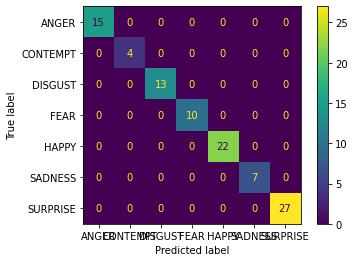

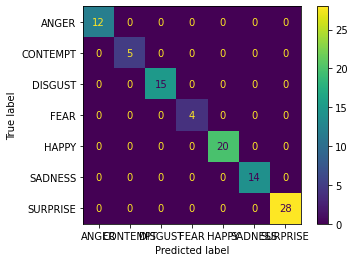

BOOTSTRAP
El error es de: 0.005893340412085257
La varianza es de: 7.946684977133372e-05
PROMEDIO:  0.9894825220108032


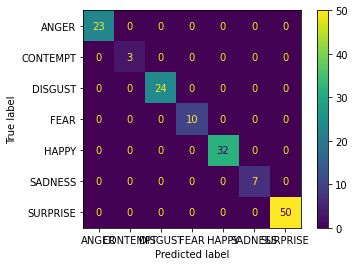

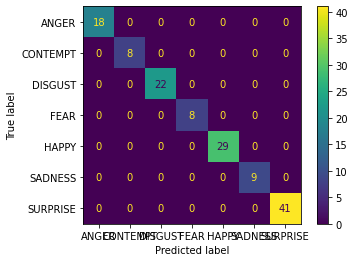

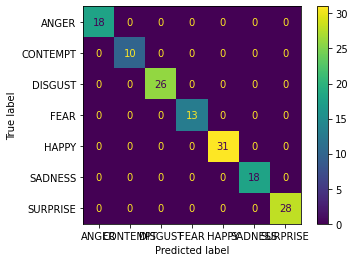

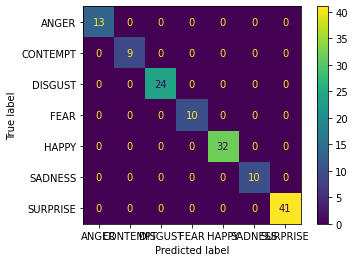

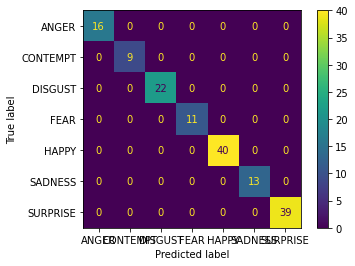

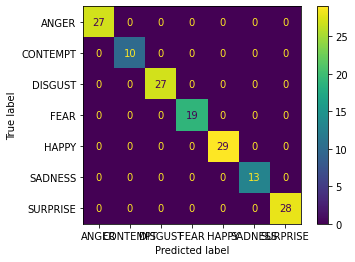

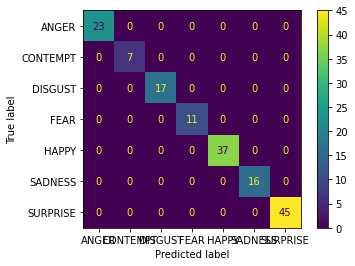

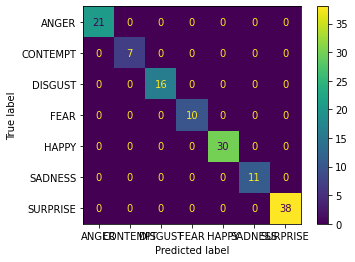

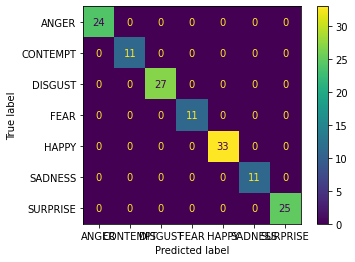

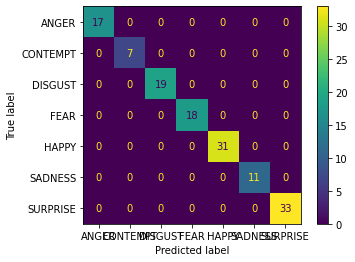

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


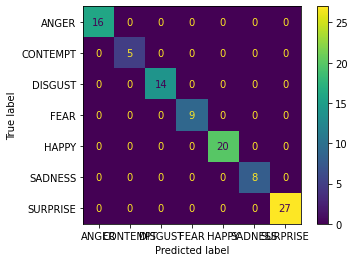

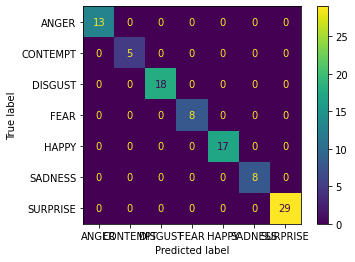

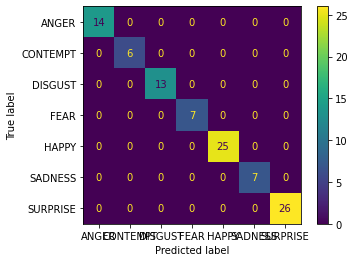

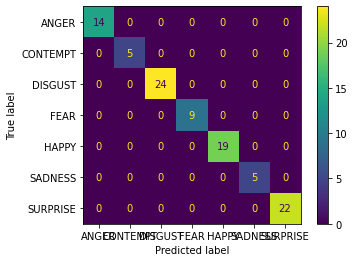

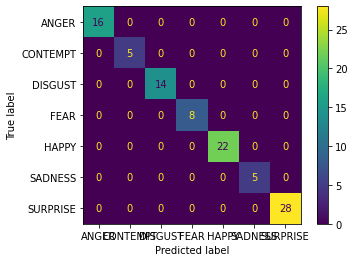

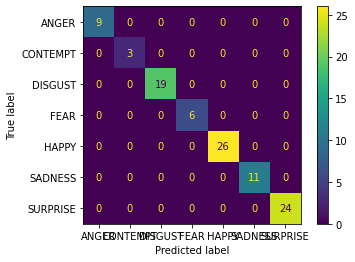

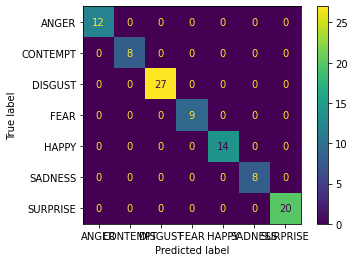

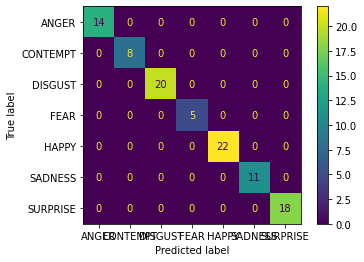

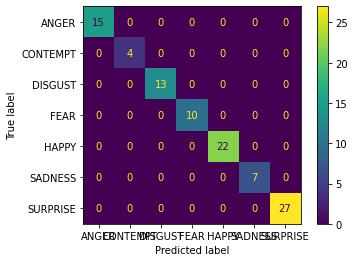

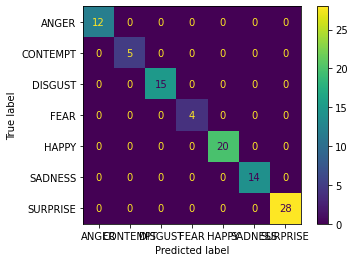

BOOTSTRAP
El error es de: 0.0022611701909819315
La varianza es de: 1.3303379271215785e-05
PROMEDIO:  1.1335619688034058


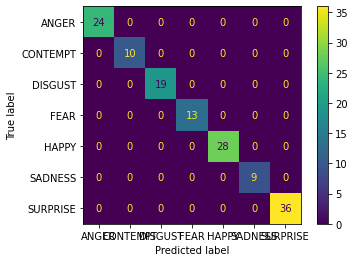

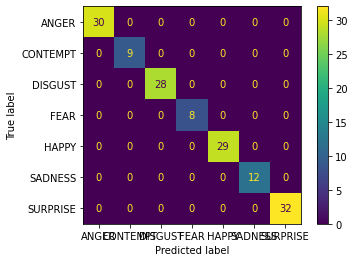

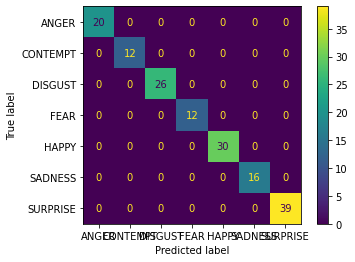

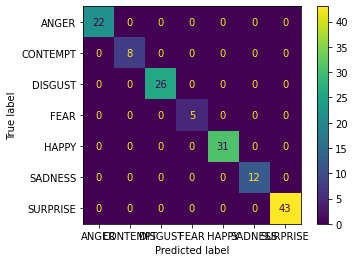

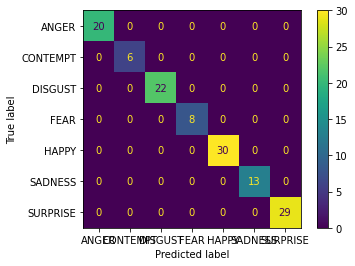

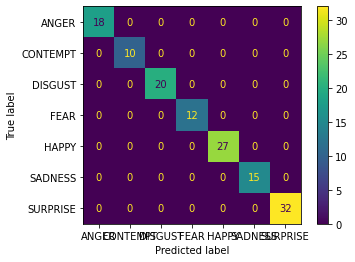

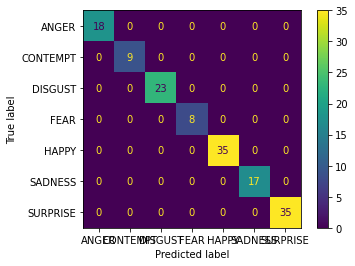

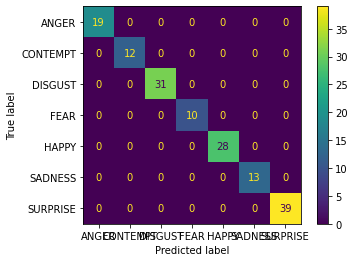

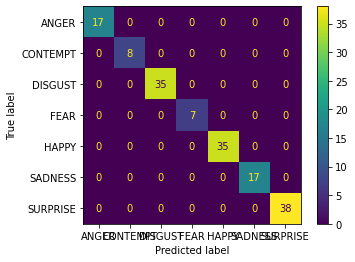

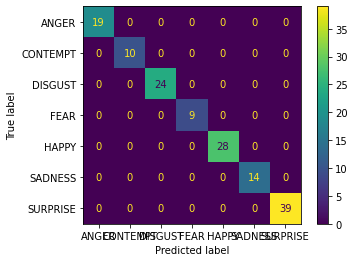

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


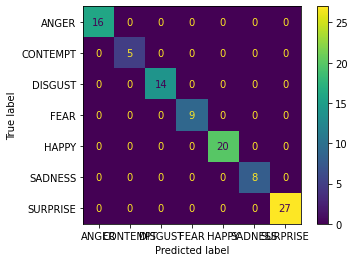

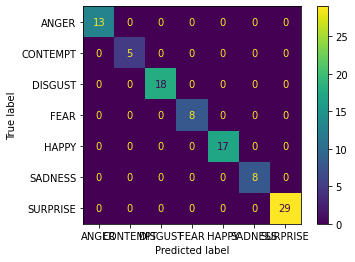

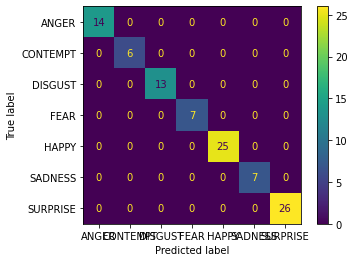

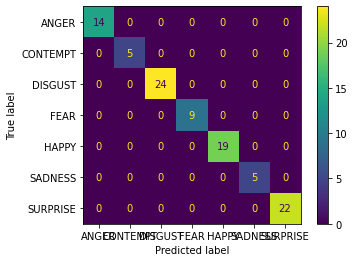

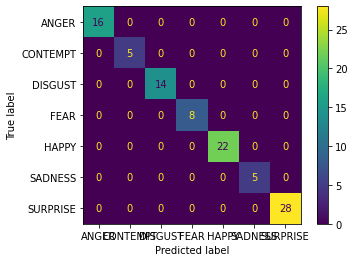

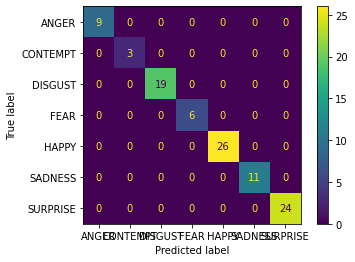

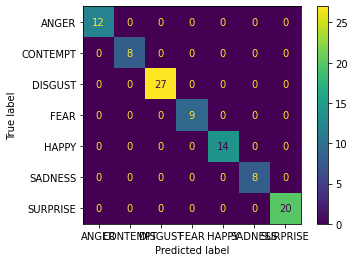

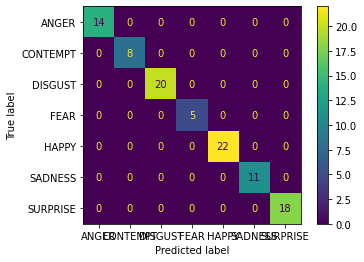

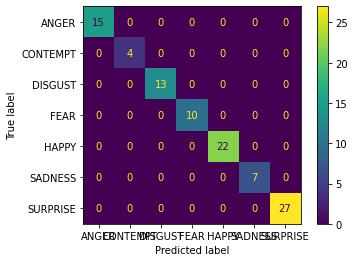

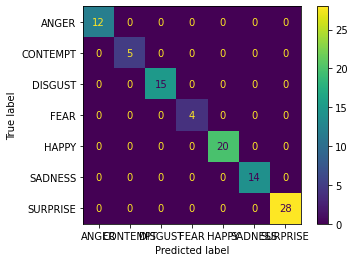

BOOTSTRAP
El error es de: 0.004114414541355504
La varianza es de: 7.534766512739754e-05
PROMEDIO:  1.0063644647598267


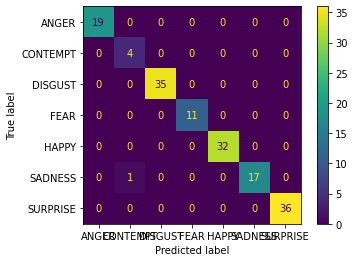

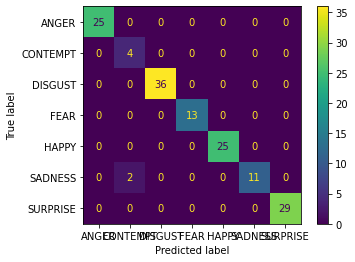

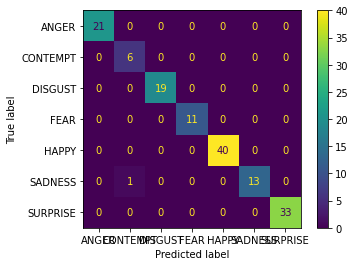

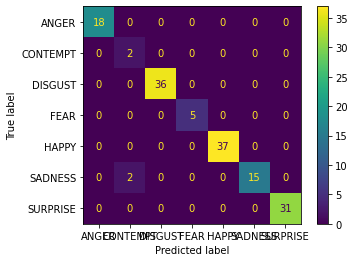

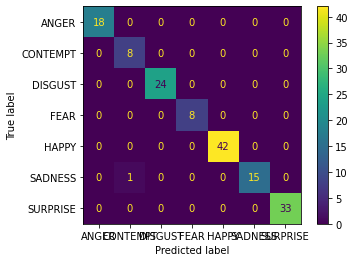

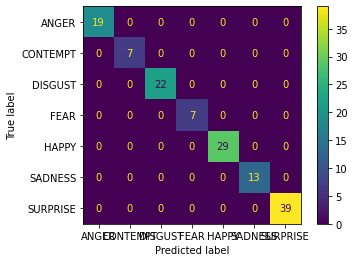

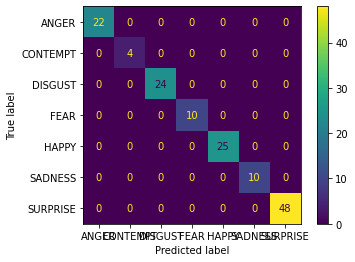

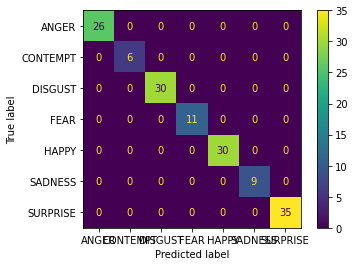

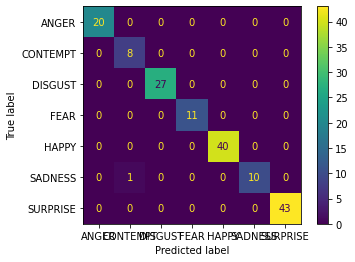

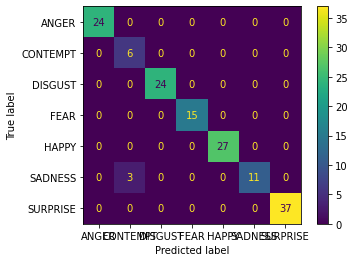

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


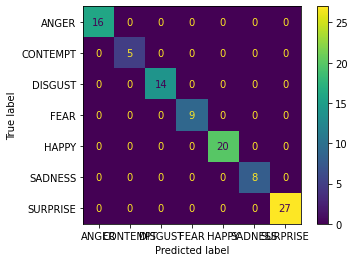

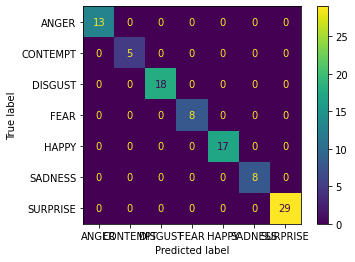

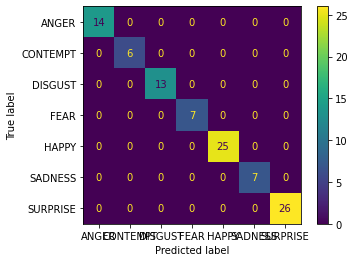

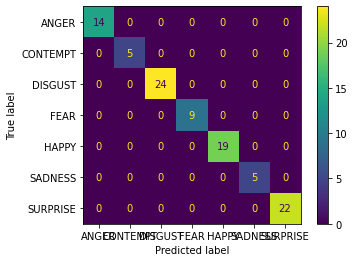

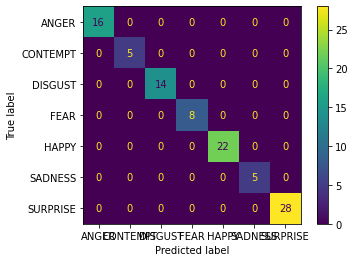

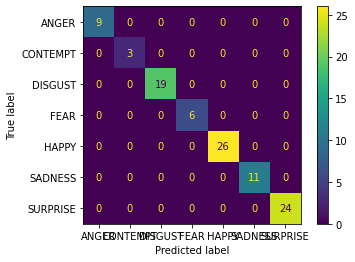

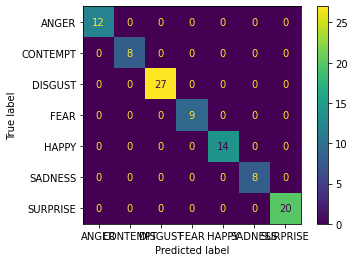

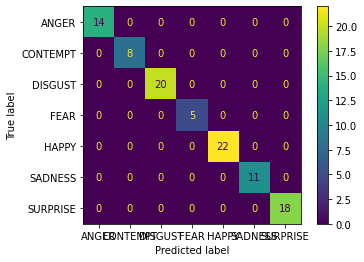

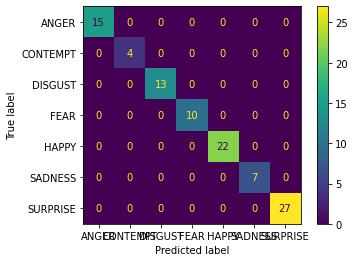

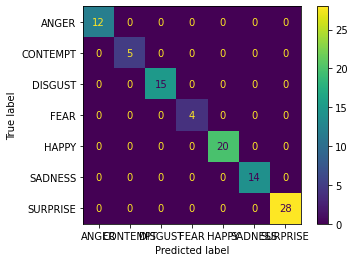

BOOTSTRAP
El error es de: 0.0033071518080916686
La varianza es de: 3.8333254622616706e-05
PROMEDIO:  0.9102809429168701


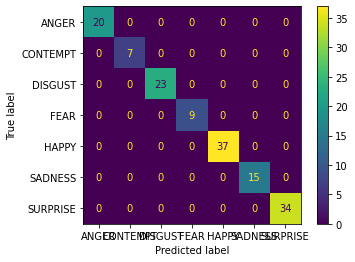

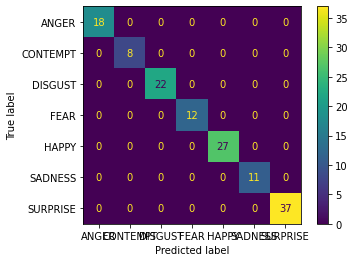

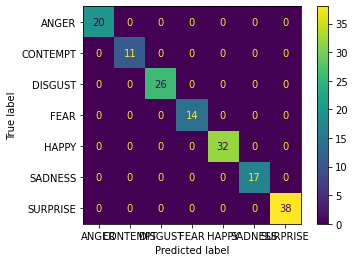

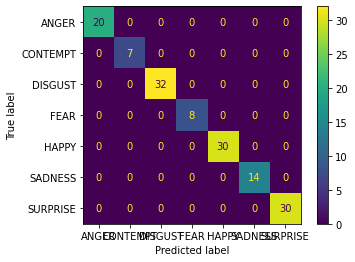

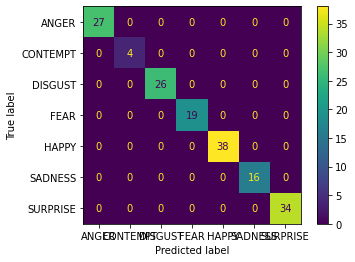

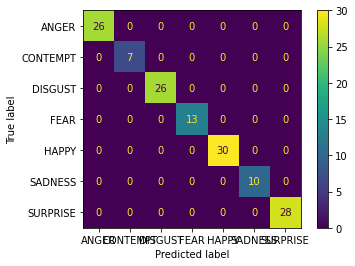

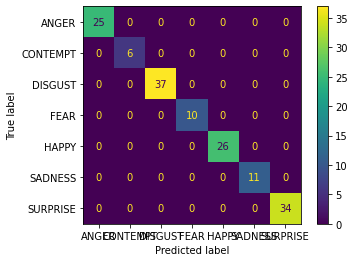

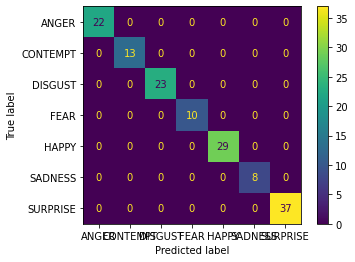

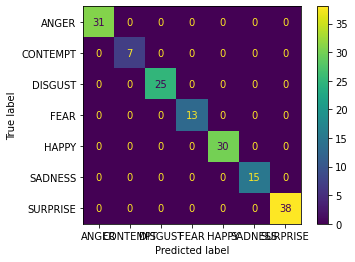

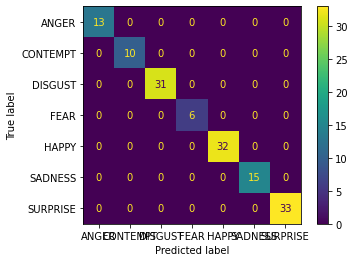

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


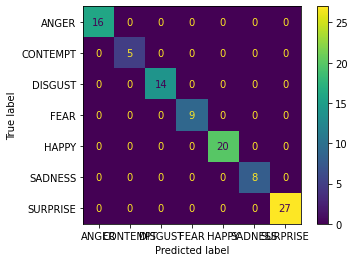

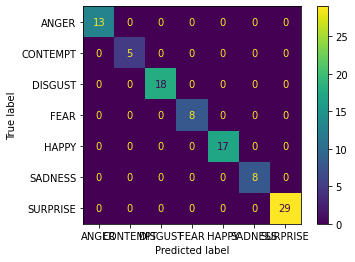

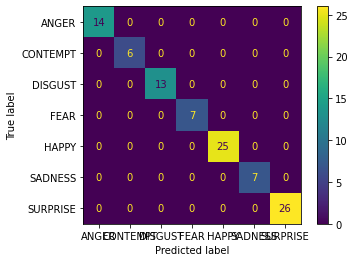

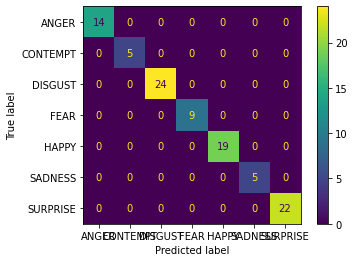

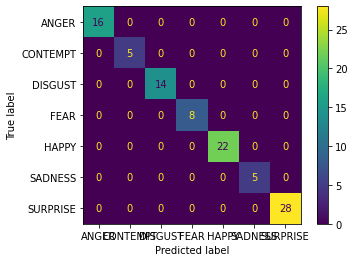

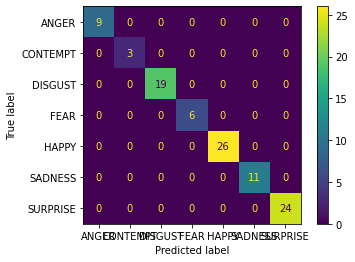

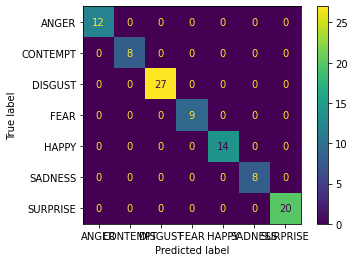

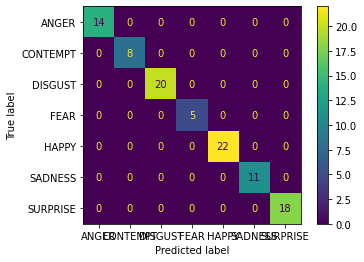

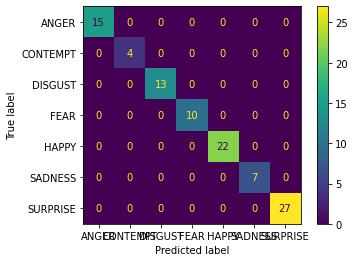

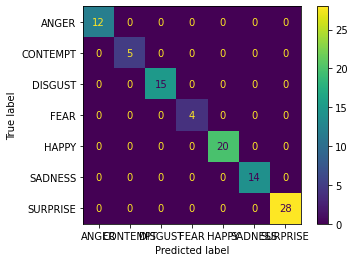

BOOTSTRAP
El error es de: 0.0020408163265306146
La varianza es de: 4.164931278633912e-05
PROMEDIO:  0.9304654598236084


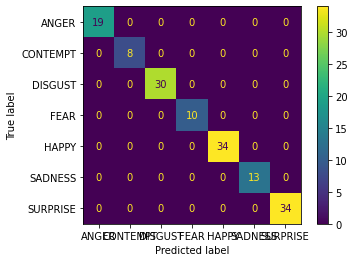

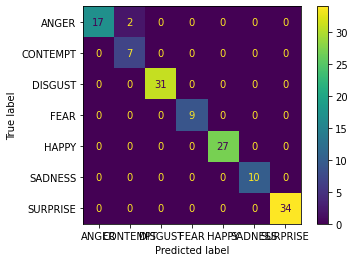

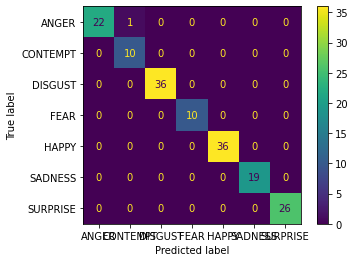

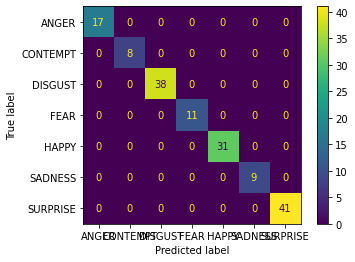

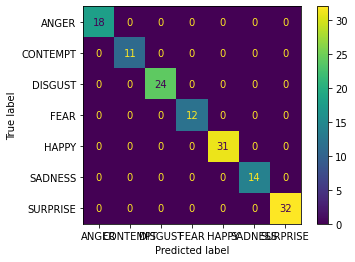

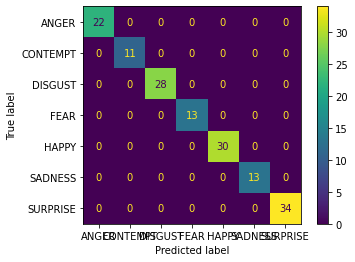

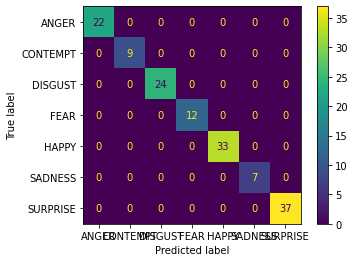

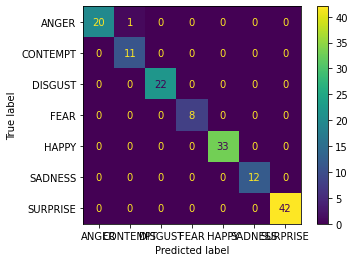

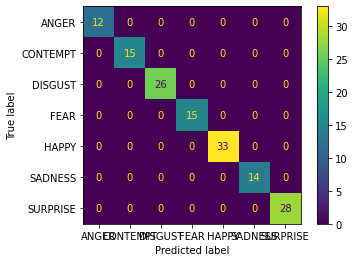

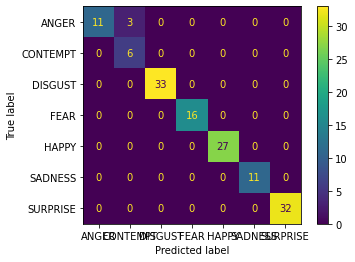

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


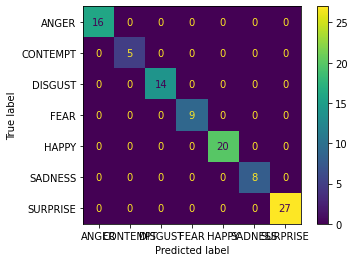

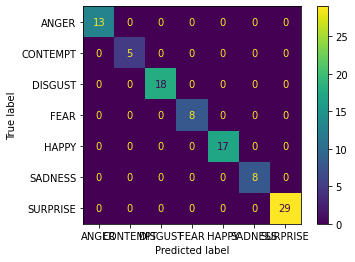

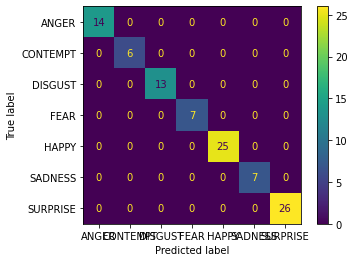

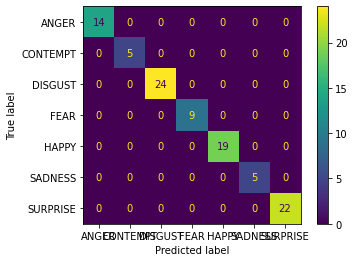

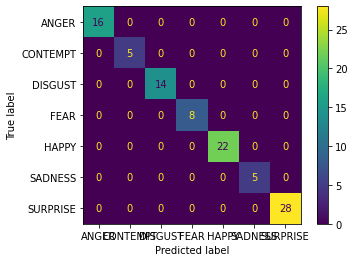

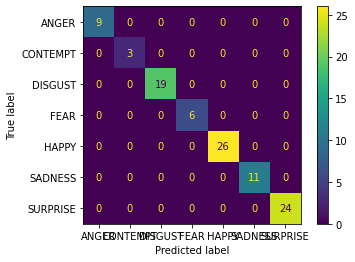

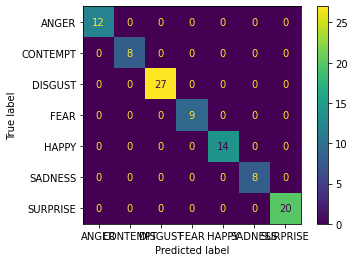

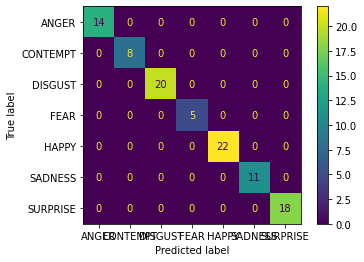

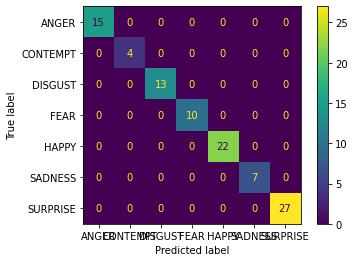

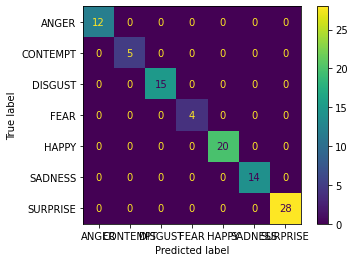

BOOTSTRAP
El error es de: 0.006270588235294116
La varianza es de: 0.000236340023068051
PROMEDIO:  0.8911129236221313


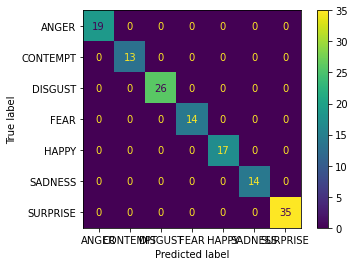

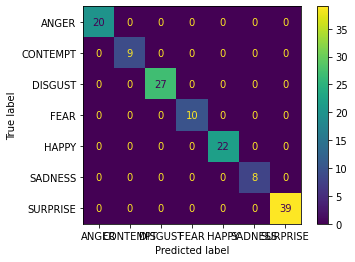

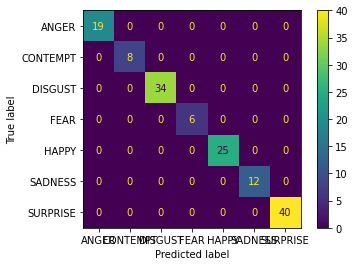

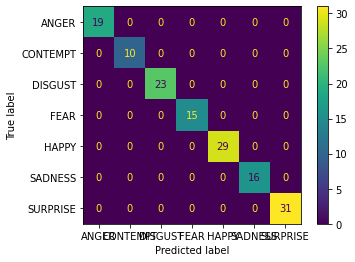

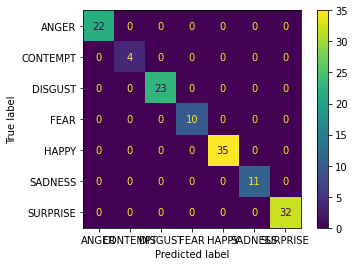

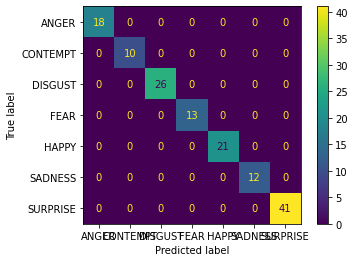

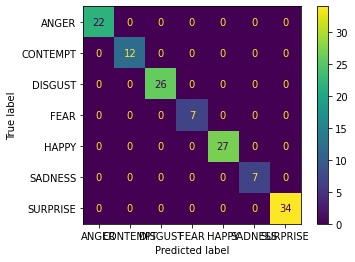

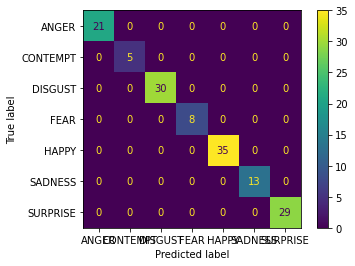

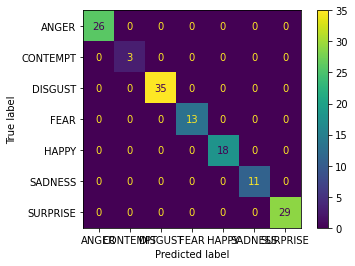

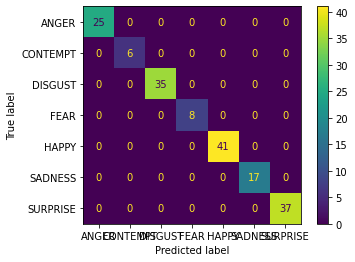

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


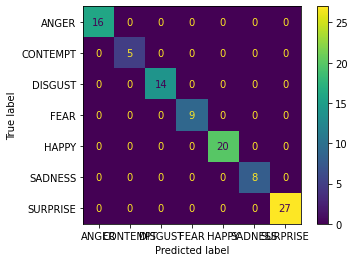

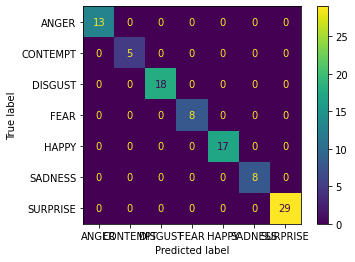

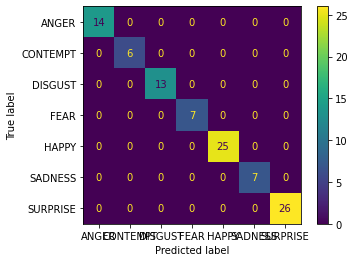

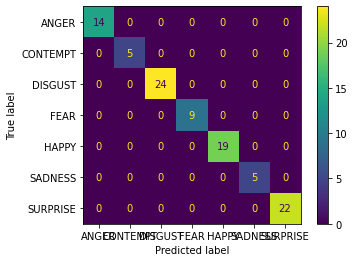

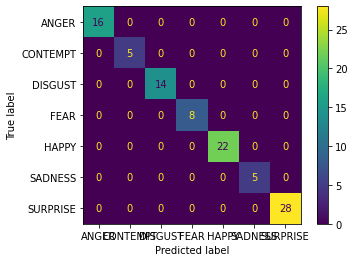

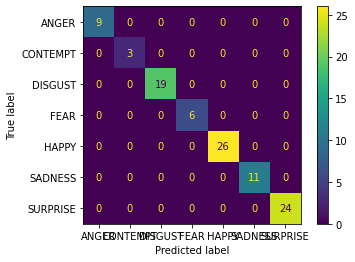

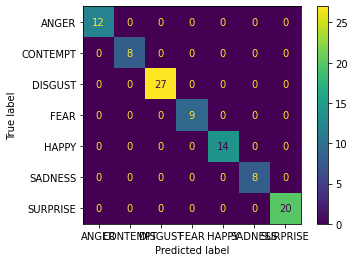

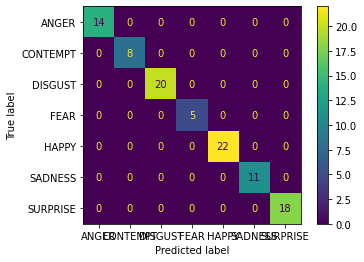

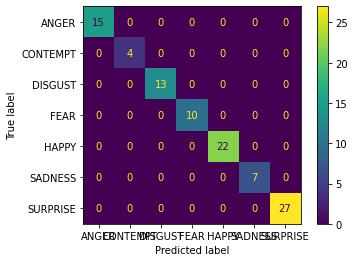

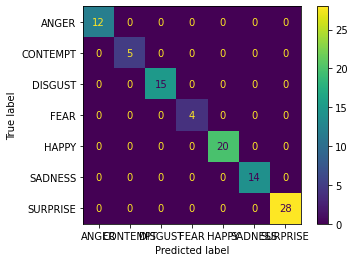

BOOTSTRAP
El error es de: 0.007181198108570652
La varianza es de: 0.00010226634866981588
PROMEDIO:  0.9679896831512451


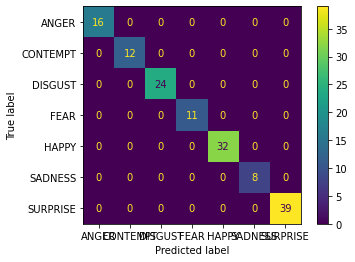

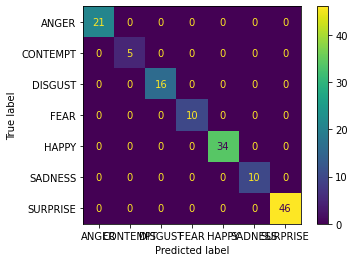

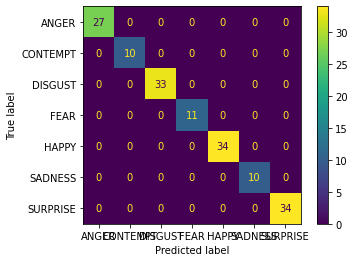

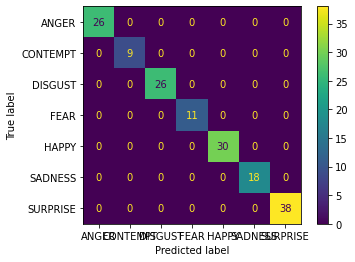

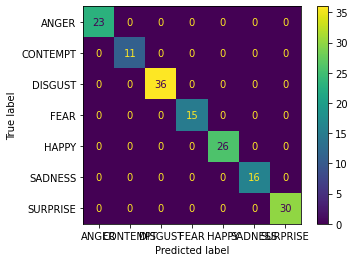

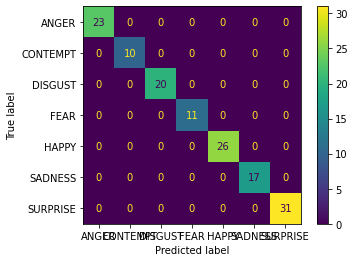

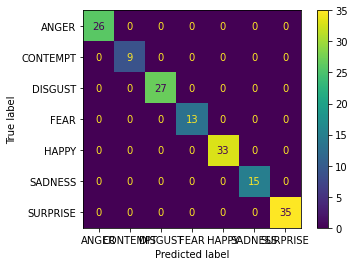

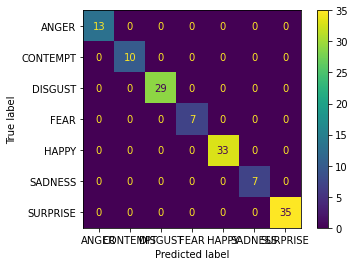

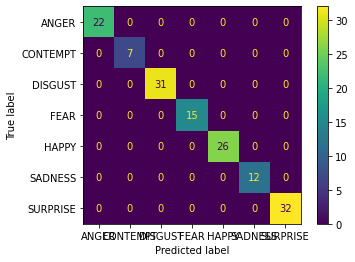

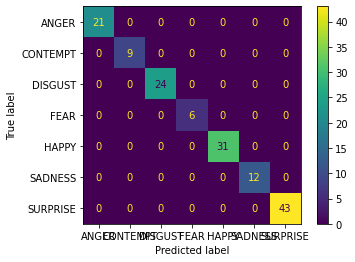

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


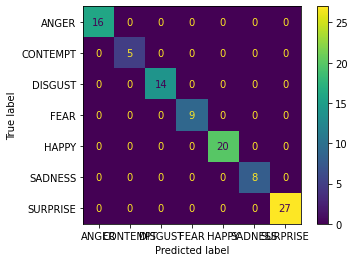

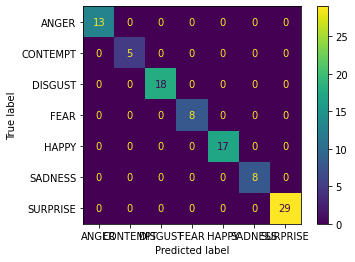

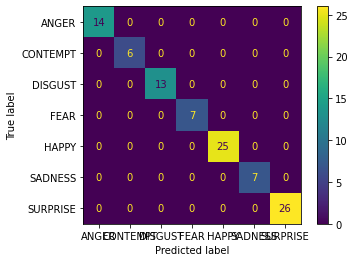

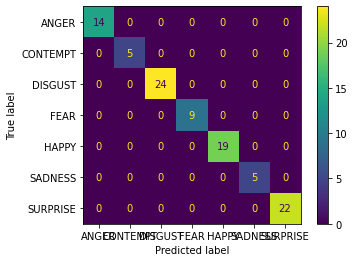

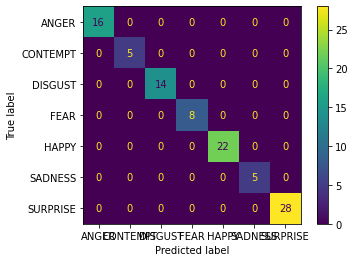

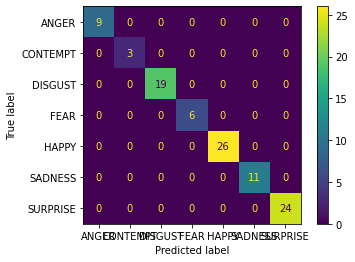

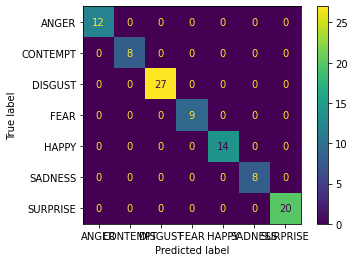

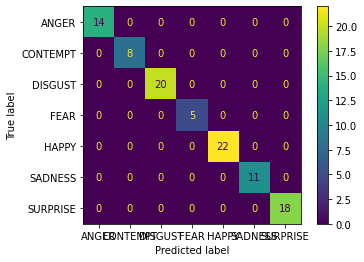

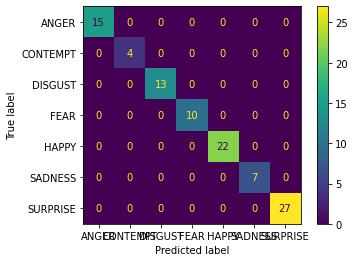

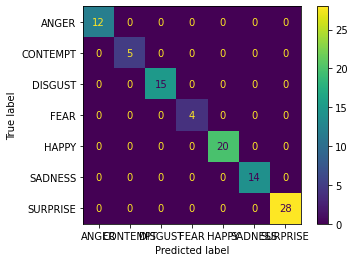

BOOTSTRAP
El error es de: 0.0027397260273972603
La varianza es de: 7.506098705197975e-05
PROMEDIO:  1.2015659809112549


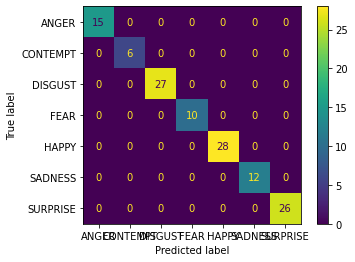

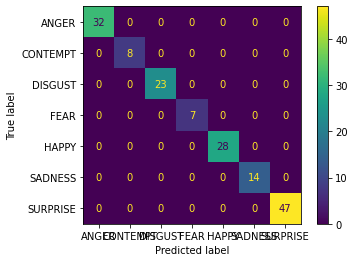

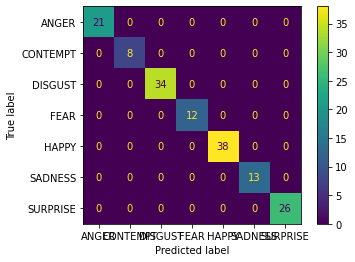

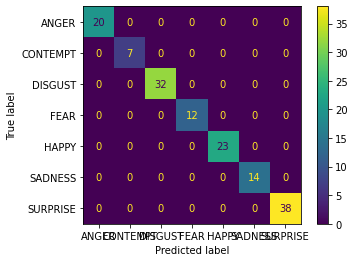

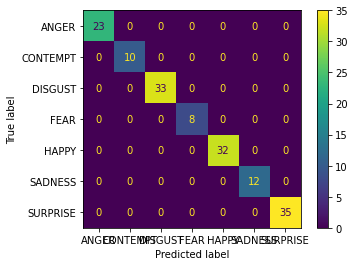

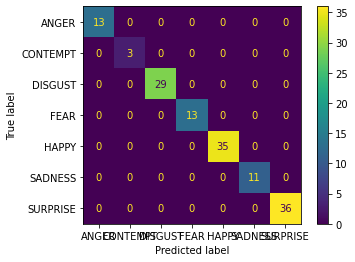

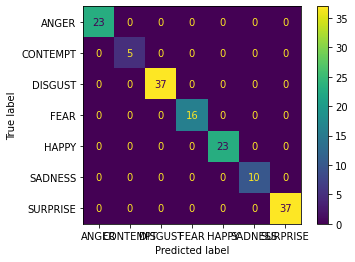

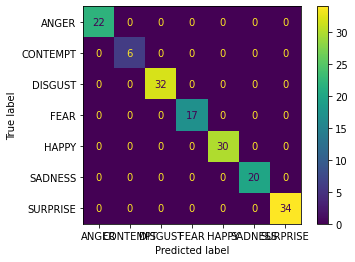

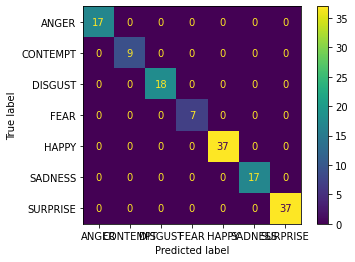

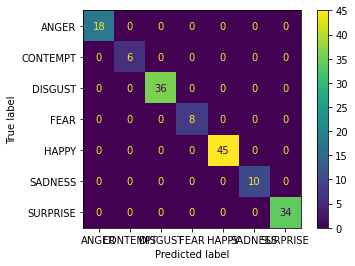

K-FOLD
El error es de: 0.0011111111111111072
La varianza es de: 1.234567901234559e-05


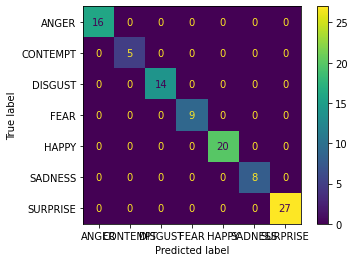

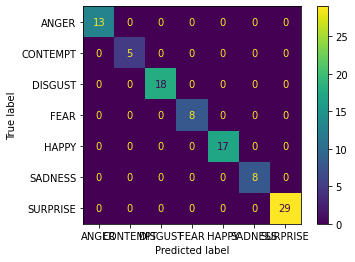

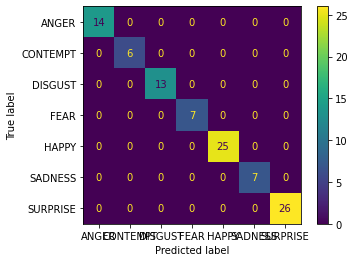

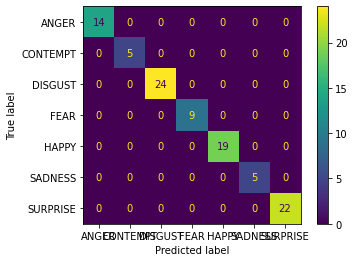

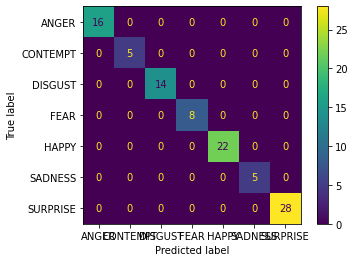

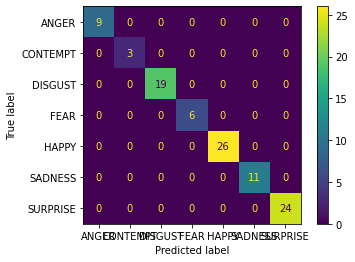

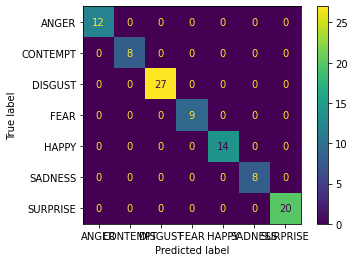

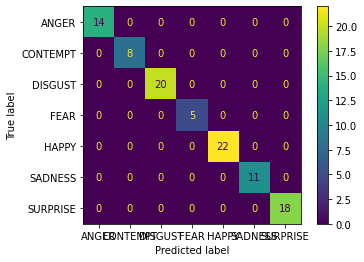

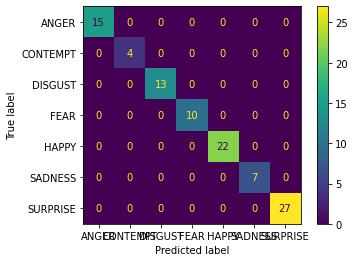

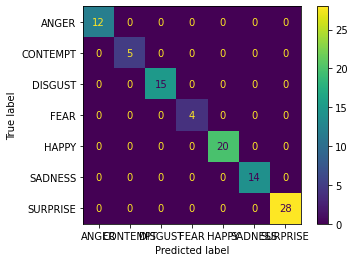

BOOTSTRAP
El error es de: 0.0037605442176870786
La varianza es de: 6.885456985515307e-05
PROMEDIO:  1.1510626077651978


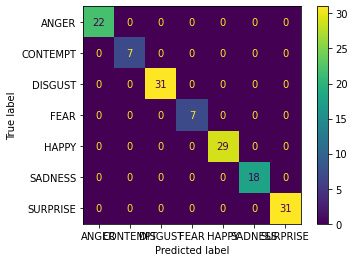

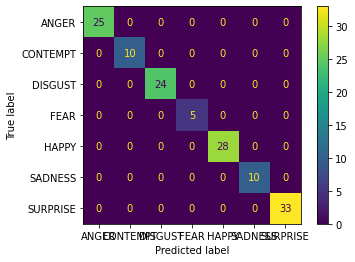

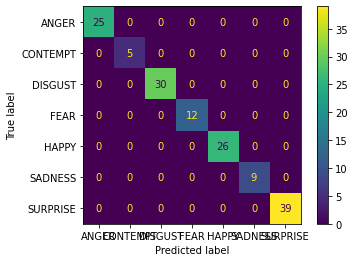

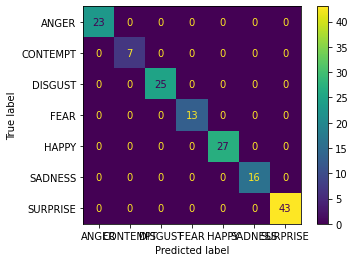

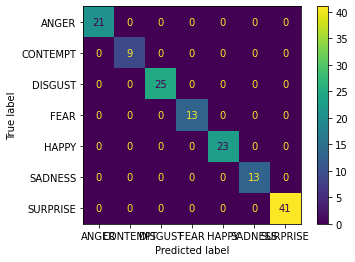

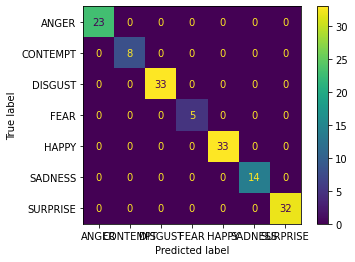

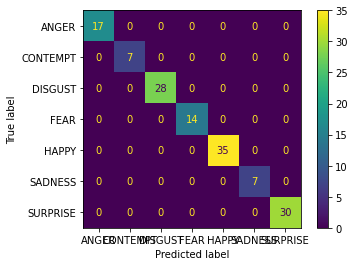

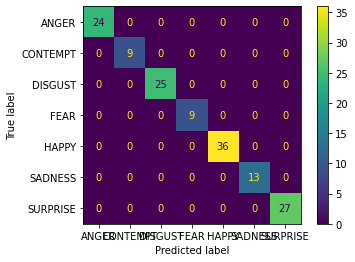

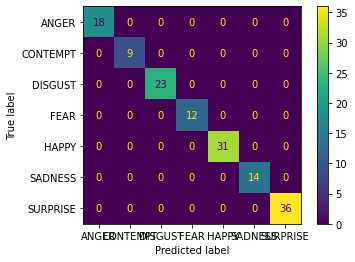

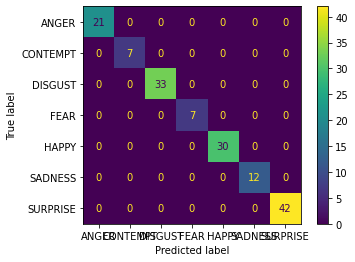

K-FOLD
El error es de: 0.007528896420674292
La varianza es de: 5.2710302671993305e-05


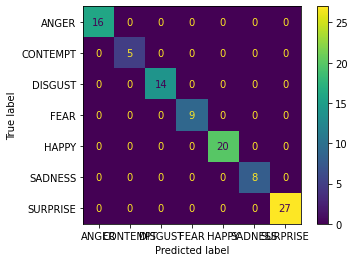

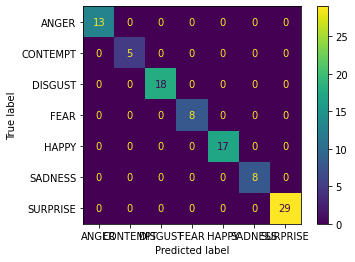

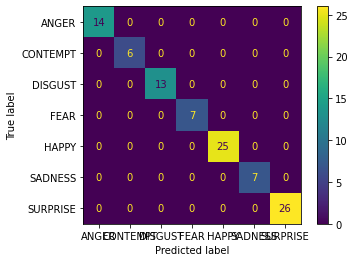

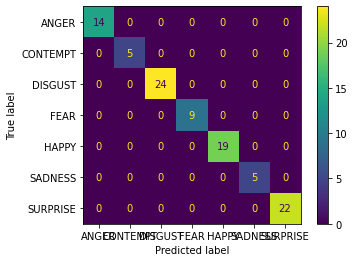

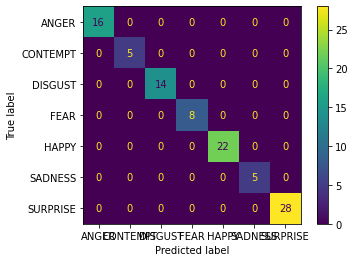

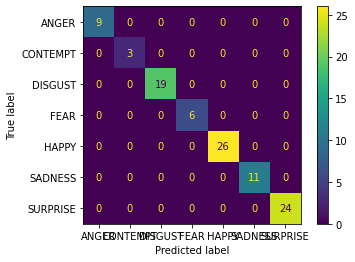

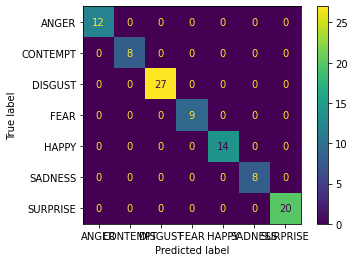

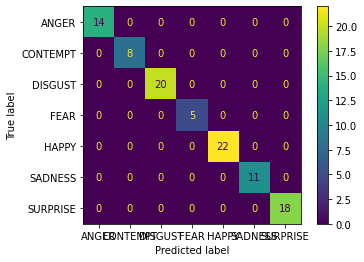

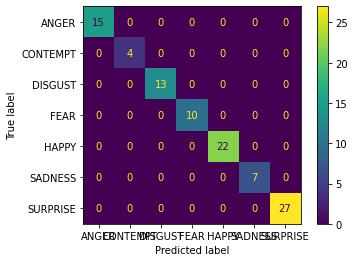

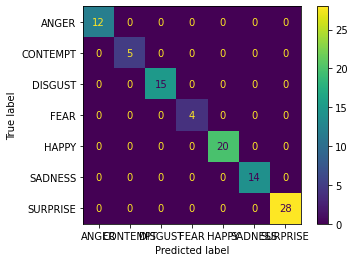

BOOTSTRAP
El error es de: 0.011674506678734532
La varianza es de: 0.00018588801206784091
PROMEDIO:  0.9332388639450073


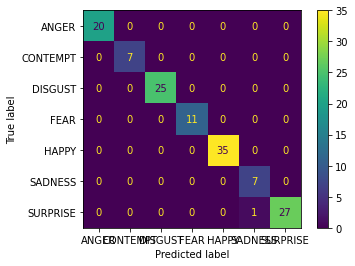

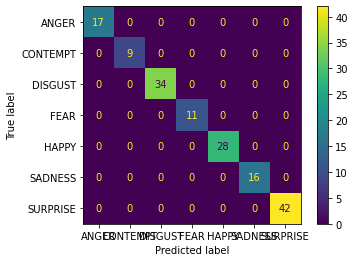

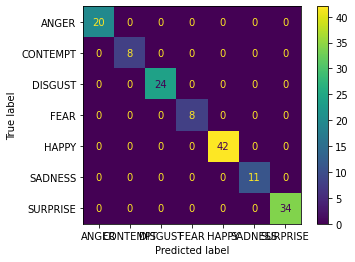

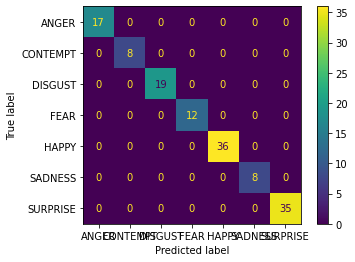

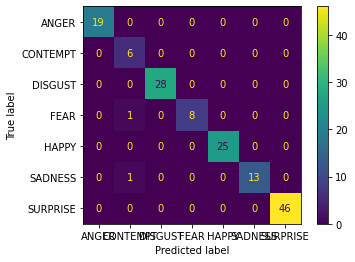

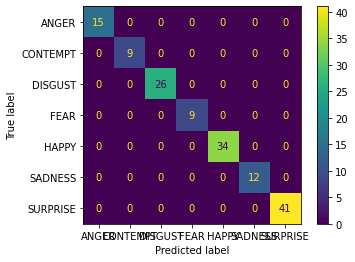

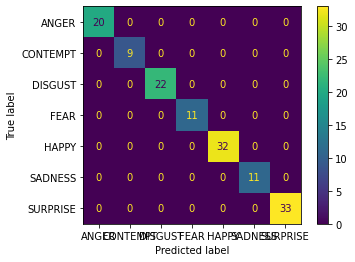

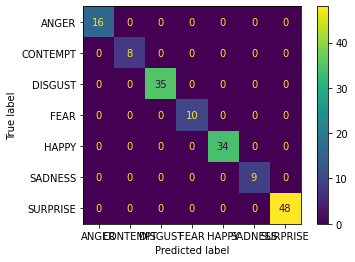

In [147]:
k = 10

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
gammas = [1, 0.1, 0.00001, 'scale']
Cs = [1, 10, 50, 100, 1000]

for kernel in kernels:
  f = open("experimentos.txt", "a")
  f.write('=====' + kernel + '=====\n')
  f.close()
  for gamma in gammas:
    for C in Cs:
      modelo1 = svm.SVC(gamma=gamma, C=C, kernel=kernel)
      modelo2 = svm.SVC(gamma=gamma, C=C, kernel=kernel)
      print('K-FOLD')
      start = time.time()
      result_k_folds = k_folds(X, Y, modelo1, k)
      end = time.time()
      # print('Tiempo total de testing con', 'k-folds (k = ' + str(k) + ')', end-start, 'segundos.')
      t_k = end-start
      # NOTE: lo de abajo, descomentado, muestra las matrices de confusion
      # for result in result_k_folds:
      #     plot_confusion_matrix(result[0], result[1], result[2])  
      #     plt.show()

      print('BOOTSTRAP')
      start = time.time()
      result_bootstrap = bootstrap(X, Y, modelo2, k)
      end = time.time()
      # print('Tiempo total de testing con bootstrap (' + str(k) + ' experimentos)', end-start, 'segundos.')
      t_b = end-start
      print('PROMEDIO: ', (t_k+t_b)/2)
      f = open("experimentos.txt", "a")
      f.write(' & ' + str(round((t_k+t_b)/2, 3)) + '\\\\ \n')
      f.close()
      # NOTE: lo de abajo, descomentado, muestra las matrices de confusion
      # for result in result_bootstrap:
      #     plot_confusion_matrix(result[0], result[1], result[2])  
      #     plt.show()
      

# dado que el C (parametro de regularizacion) es inversamente proporcional a la 
# magnitud de la regularizacion, entonces el hecho de que ocurra un mejor ajuste
# cuando el C es grande, significa que este modelo no necesita mucha regularizacion